In [1]:
import graph_tool as gt
from graph_tool.draw import graph_draw
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import torch.optim.lr_scheduler as lr_scheduler
import torch.optim as optim
from model import Opt_GMM_Mapper
from model import Trainer
from model import Soft_Mapper
import torch.distributions as D
from gudhi.cover_complex import MapperComplex
from scipy.stats import ks_2samp
import matplotlib.patches as mpatches
from scipy.spatial import distance
torch.manual_seed(0) #fix seed
np.random.seed(42)

/home/farmer/miniconda3/envs/dl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def Lor_distance(X, c): #X: n*dim c: 1*dim
    # centering
    X = X-c
    # add x_0
    x0 =  torch.sqrt(torch.norm(X, p=2, dim=1)**2 + 1)
    X = torch.cat((x0.unsqueeze(1), X), dim=-1)

    g = torch.eye(X.size()[1],dtype=float)
    g[0,0] = -1
    term1 = torch.matmul(X,g)
    r = torch.matmul(term1, X.T)
    dis = torch.acosh(-r)
    dis.fill_diagonal_(fill_value=0)
    return dis

def mean_lor_distance(X):
    dis_list =[]
    for i in range(X.size()[0]):
        dis_list.append(Lor_distance(X, X[i,:]))
    dis_list = torch.stack(dis_list)
    #dis = torch.mean(dis_list, dim=0)
    dis = torch.mean(dis_list, dim=0) #/torch.std(dis_list, dim=0)
    dis.fill_diagonal_(0.)
    return dis

def matrix_lor_distance(X):
    dis_list =[]
    for i in range(X.size()[0]):
        dis_list.append(Lor_distance(X, X[i,:]))

    dis_list = torch.stack(dis_list) #n*n*n
    n = dis_list.shape[0]
    distance_matrix = torch.zeros((n, n))
    
    for i in range(n):
        for j in range(i+1, n):
            distance = torch.norm(dis_list[i] - dis_list[j], p=2)
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance
    return distance_matrix

import math
def query_braak(data_num, data_path, verbo = False):
    data = pd.read_csv(data_path,index_col=0)
    id_list = data.index
    id = id_list[data_num]

    indi_speci_data = pd.read_csv("data/MSBB_biospecimen_metadata.csv")
    indi_speci_data = np.array(indi_speci_data)
    indi_speci_data = indi_speci_data[:,[0,1]]

    id_loc = np.where(indi_speci_data == id)
    individualID = indi_speci_data[id_loc[0],id_loc[1]-1]
    if len(individualID) == 0:
        return 0
    individualID = individualID[0]
    if type(individualID) != str:
        if math.isnan(individualID):
            return 0
    
    #17
    indi_braak_data = pd.read_csv("data/MSBB_individual_metadata.csv")
    indi_braak_data = np.array(indi_braak_data)
    b_loc = np.where(indi_braak_data == individualID)
    braak = indi_braak_data[b_loc[0],17][0]
    if verbo:
        print("individualID:{}".format(individualID))
        print("braak:{}".format(braak))

    return braak

def qurey_frac(clusters,j,data_path):
    non_zero_indices = torch.nonzero(clusters[:,j])
    non_zero_indices = non_zero_indices[:,0]
    node_j_list = [] #node j 里的braak值的集合
    for ind in non_zero_indices:
        node_j_list.append(query_braak(int(ind),data_path))
    
    count  = list(np.bincount(np.array(node_j_list)))
    
    l = len(count)
    if l < 7 :
        count = count + [0]*(7-l)
    count = np.array(count)
    return count/count.sum(), count

def qurey_frac_all(clusters,data_path):
    non_zero_indices = torch.nonzero(clusters)
    non_zero_indices = non_zero_indices[:,0]
    node_j_list = [] #每个node里的braak值的集合
    for ind in non_zero_indices:
        node_j_list.append(query_braak(int(ind),data_path))
    
    count  = list(np.bincount(np.array(node_j_list)))
    l = len(count)
    if l < 7 :
        count = count + [0]*(7-l)
    count = np.array(count)
    print(count.sum())
    return count/count.sum(), count

def analysis_braak(G_mode, train, data_path, projected_data, good_nodes, x_lim, y_lim):
    clusters = train.mode_clusters
    clusters = clusters.squeeze(dim = 0)
    clusters = clusters[:, ~torch.all(clusters == 0, dim=0)]

    #color_list = ['#F5F5F5','#DCDCDC','#C0C0C0','#969696','#656565','#404040','#000000']
    #color_list = ['#54B345','#32B897','#BB9727','#05B9E2','#8983BF','#C76DA2','#F27970']
    color_list = ["#76da91", "#63b2ee", "#7cd6cf","#9192ab", "#f8cb7f", "#efa666", "#f89588"]
    graph_gt = gt.Graph(directed=False)
    pie_fractions = graph_gt.new_vertex_property("vector<double>")
    pie_colors = graph_gt.new_vertex_property("vector<string>")
    node_text = graph_gt.new_vertex_property("string")

    vertex_map = {node: graph_gt.add_vertex() for node in G_mode.nodes()}

    # add
    for i in G_mode.nodes():
        frac, count = qurey_frac(clusters,i,data_path)
        pie_fractions[i] = list(frac)
        pie_colors[i] = color_list
        #node_text[i] = "{};{}".format(int(count.sum()),i)
        node_text[i] = "{}".format(i)  #node id

    for i,e in enumerate(G_mode.edges()):
        u,v = e
        graph_gt.add_edge(vertex_map[u], vertex_map[v])

    graph_draw(graph_gt,  vprops={"shape": "pie", "pie_fractions": pie_fractions, "pie_colors": pie_colors,
                                "text": node_text, "size":40, "text_position":2, "font_size":20},output="graph.eps")

    plt.figure(figsize=(12, 9),dpi=500)  
    plt.subplot(221)
    plt.imshow(plt.imread('graph.eps'), aspect='auto')  
    plt.axis('off')  
    plt.title("Mapper graph")
    proxy_artists = []

    frac_all, count_all = qurey_frac_all(clusters,data_path)
    labels = ['0', '1','2','3','4','5','6']
    radius = 0.01  # 一个很小的半径
    proxy_wedges = []
    for i, color in enumerate(color_list):
        # 创建一个圆形楔形作为代理艺术家
        wedge = mpatches.Wedge(center=(0, 0), r=radius, theta1=0, theta2=360, color=color)
        proxy_wedges.append(wedge)
    plt.legend(handles=proxy_wedges, labels=labels, fontsize='small')
    #ax[1].pie(frac_all, labels=['0', '1','2','3','4','5','6'], colors=color_list)

    values = np.zeros(7)
    for node_id in good_nodes:
        _, count = qurey_frac(clusters,node_id,data_path)
        values = values + count

    # 对应的类别
    categories = [0,1,2,3,4,5,6]
    plt.subplot(222)
    # 创建柱状图
    plt.bar(categories, values,alpha = 0.5, color = "#FEA3A2", label = "Some good")
    plt.bar(categories, count_all,bottom=values, color = "#8E8BFE", label = "All")
    # 添加标题和标签
    #plt.bar_label(b)
    plt.legend()
    plt.title('Bar Chart')
    plt.xlabel('Braak value')
    plt.ylabel('num of people')
    plt.legend(fontsize='small')

    # GMM PDF
    m = train.Mapper
    x = torch.linspace(float(torch.min(m.means))-0.1,float(torch.max(m.means))+0.1, 1000)
    mix = D.Categorical(probs=m.weights)
    comp = D.Normal(m.means, torch.sqrt(m.covariances.abs())) #注意这里abs
    gmm = D.MixtureSameFamily(mix,comp)
    pdf = gmm.log_prob(x).exp()

    plt.subplot(212)
    # density
    plt.plot(x.detach().numpy(), pdf.detach().numpy())

    mode_H = train.mode_assignmnets
    #mode_H = mode_H[:, ~torch.all(mode_H == 0, dim=0)] #去掉没有被分到点的一类


    labels = []
    num_points,num_classes = mode_H.size()
    for i in range(num_points):
        for j in range(num_classes):
            if mode_H[i][j] >= 1.:
                labels.append(j)
                break
    labels = torch.tensor(labels)

    # (color, mark)

    class_colors = ['#FFBE7A','#FA7F6F','#82B0D2']
    marks = [ ".", ",", "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*",
    "h", "H", "+", "x", "X", "D", "d", "|", "_" ]

    color_mark_bank = []
    color_index = 0
    mark_index = 0
    for j in range(num_classes):
        color_index += 1
        mark_index += 1

        if color_index == len(class_colors):
            color_index = 0

        if mark_index == len(marks):
            mark_index = 0
        color_mark_bank.append([class_colors[color_index], marks[mark_index]])


    # 重新排一下序
    means, indices = torch.sort(m.means)
    mode_H = mode_H[:,indices]

    #check, delete the class that has no points
    check = mode_H.sum(dim = 0)
    zero_indices = torch.nonzero(check == 0)
    if zero_indices.numel() != 0:
        print("class{} has no points!!!".format(list(zero_indices)[0]))


    braak_list = []
    for i in range(len(projected_data)):
        braak_list.append(query_braak(i,data_path))
        
    for j in range(num_classes):
        non_zero_indices = torch.nonzero(mode_H[:,j])
        non_zero_indices = non_zero_indices.squeeze(dim=-1)
        points = projected_data[non_zero_indices]
        color_mark = color_mark_bank[j]
        plt.scatter(points, [braak_list[k]-7 for k in non_zero_indices.tolist()], s=20,
                    c = color_mark[0], marker = color_mark[1], label=f'Class {j}')

    plt.legend(loc='upper left', fontsize='small')
    plt.xlabel('x')
    plt.ylabel('Probability Density')
    plt.title('GMM Probability Density Function')
    plt.ylim(y_lim)
    plt.xlim(x_lim)
    ax2 = plt.twinx()
    
    #ax2.scatter(points, [braak_list[k] for k in non_zero_indices.tolist()], color='white')
    ax2.set_ylabel('Braak value')
    ax2.set_ylim((-1,y_lim[1]+7))
    ax2.set_yticks([0, 1, 2, 3, 4, 5, 6])
    plt.tight_layout()
    plt.show()

    print("###########")
    test_result = ks_2samp(values, count_all)
    print(test_result)
    sign = test_result.statistic_sign
    if sign == 1:
        print("Have difference!!!")
    elif sign == -1:
        print("No differenece!!!")

    return

# 44 Hyperbolic

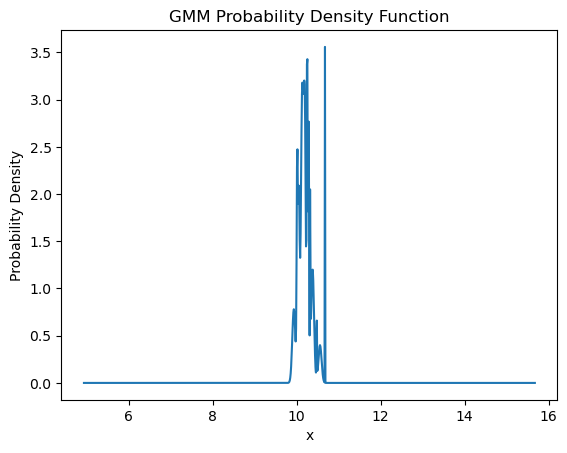

mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


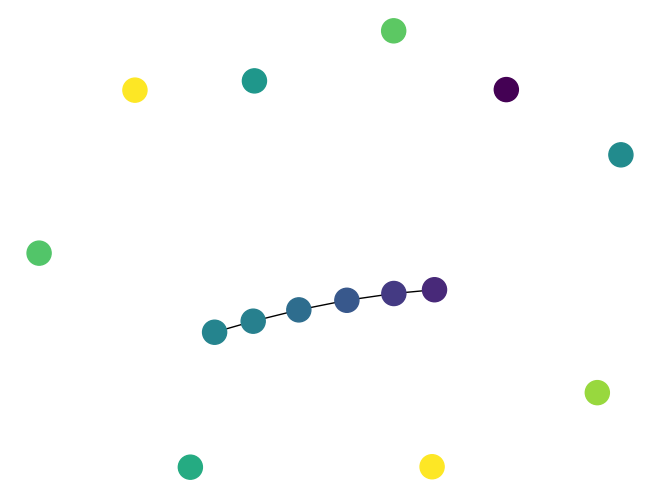

100%|██████████| 400/400 [00:07<00:00, 56.36it/s]


loss: -186.647559104765
topo_loss: -220.2916674684218
mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


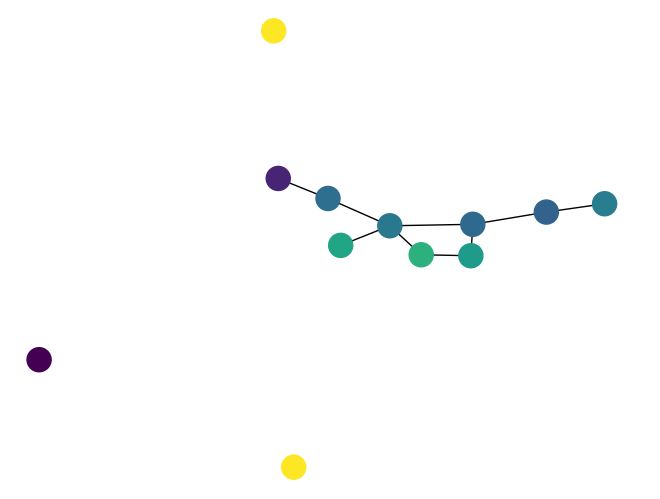

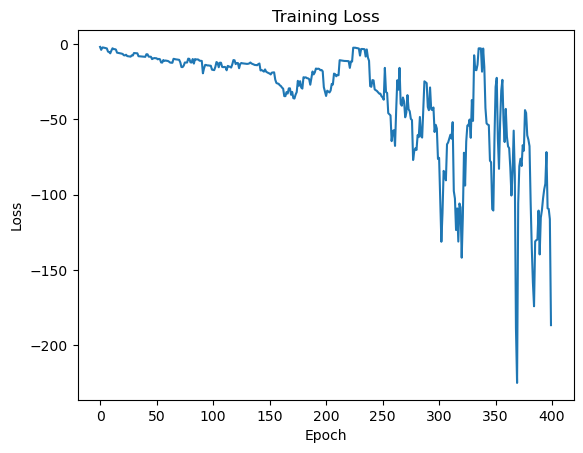

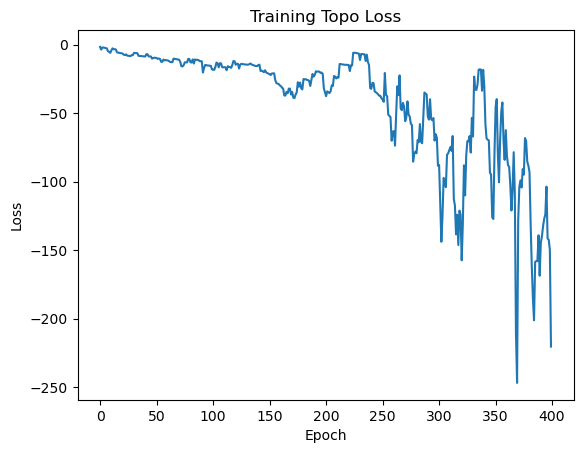

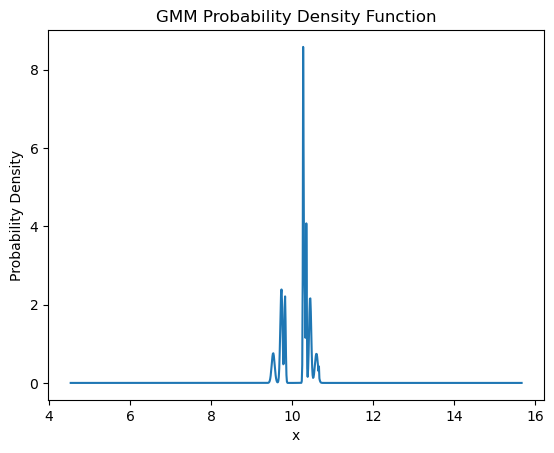

264
classtensor([1]) has no points!!!


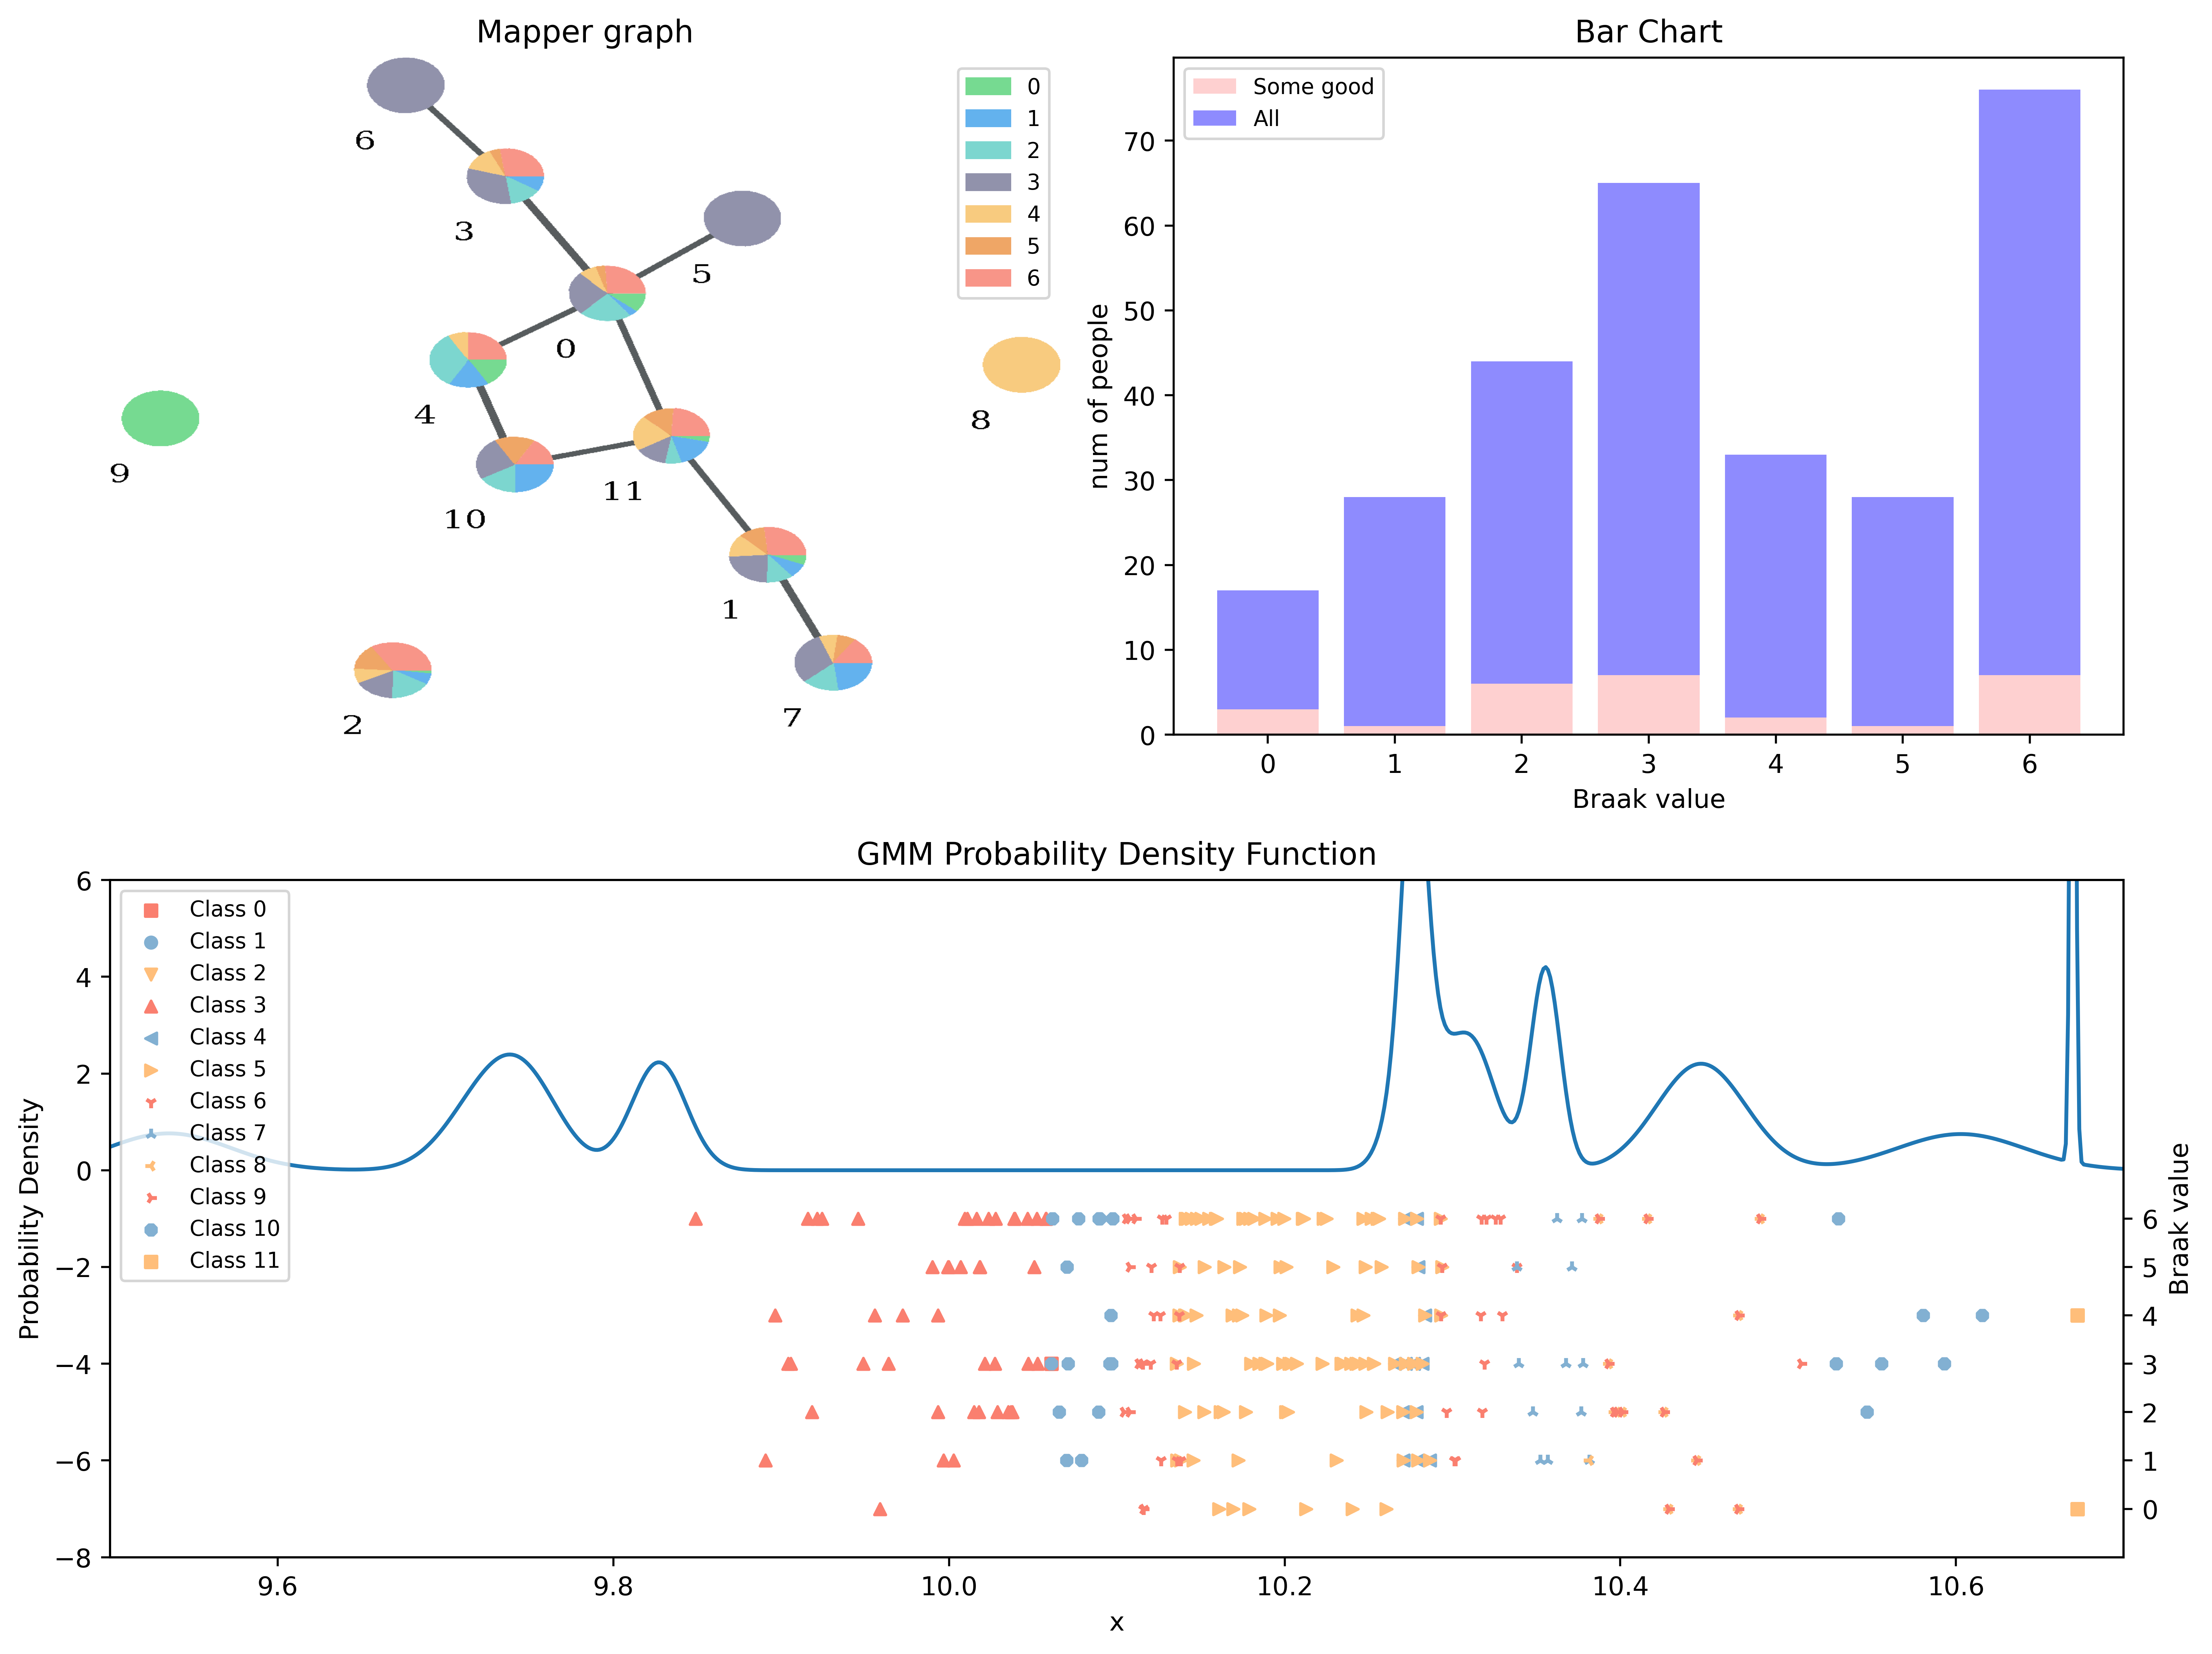

###########
KstestResult(statistic=1.0, pvalue=0.0005827505827505828, statistic_location=7.0, statistic_sign=1)
Have difference!!!


In [3]:
data_path = "data/44.csv"
df = pd.read_csv(data_path, index_col=0)
data = np.array(df)
data = torch.tensor(data,dtype=float)

dis_matrix = mean_lor_distance(data)
projected_data = torch.max(dis_matrix,dim = 1)[0]
projected_data = projected_data.view(len(projected_data),1)

n_comp = 12
num_step = 400 
l1 = 1
l2 = 1

mapper = MapperComplex(
input_type="distance matrix",
resolutions=n_comp,
gains=None,
clustering=None,
)
mapper.fit(dis_matrix.numpy(), filters=projected_data.numpy(),colors=projected_data.numpy())

cl = mapper.clustering

# GMM initialization
gmm = GaussianMixture(n_components=n_comp, covariance_type='full', n_init = 10,
                      max_iter= 1000,tol=1e-6,random_state = 0 )
gmm.fit(projected_data)
init_mean = torch.tensor(gmm.means_).view(-1)
init_var = torch.tensor(gmm.covariances_).view(-1)
init_weights = torch.tensor(gmm.weights_).view(-1)

m = Opt_GMM_Mapper(n_comp, means = init_mean, covariances=init_var, weights=init_weights, type = "distance matrix")
m.draw()
init_scheme = m.forward(projected_data, dis_matrix, cl)

# mapper before optimization
mapper = Soft_Mapper.GMM_Soft_Mapper(init_scheme, cl, data = dis_matrix, projected_data =projected_data,path='figures'
                                     ,name = 'MSBB_44',format = 'eps',type="distance matrix")
G_mode = mapper.mode(save_fig= False)

optimizer = optim.Adam(m.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1)
scheduler = lr_scheduler.StepLR(optimizer, step_size=400, gamma=0.01)

# train
train = Trainer(m, cl, num_step, optimizer, scheduler)
train.fit(dis_matrix, projected_data, l1, l2)
train.analysis()

# mapper after optimization
G_mode = train.G_mode
clusters = train.mode_clusters
good_nodes = [0] 
analysis_braak(G_mode, train, data_path, projected_data, good_nodes, (9.5,10.7),(-8, 6))

# 44 Euclid

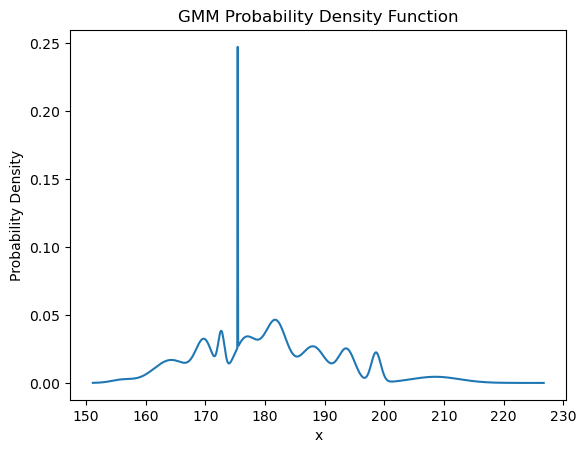

mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


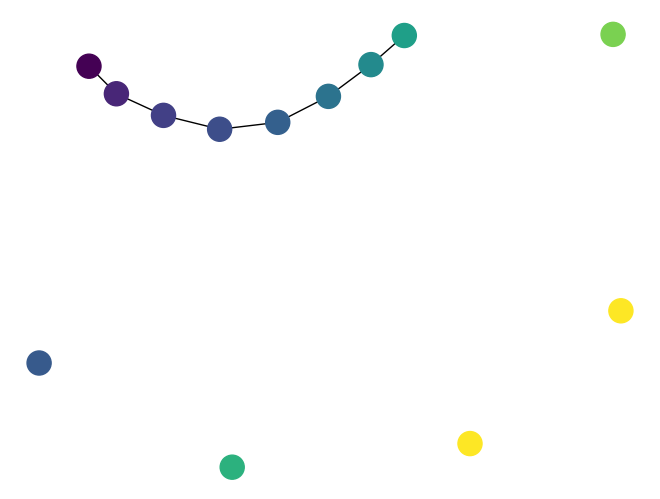

100%|██████████| 400/400 [00:05<00:00, 67.71it/s]

loss: -4.5779893154764135
topo_loss: -9.557616483407715
mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


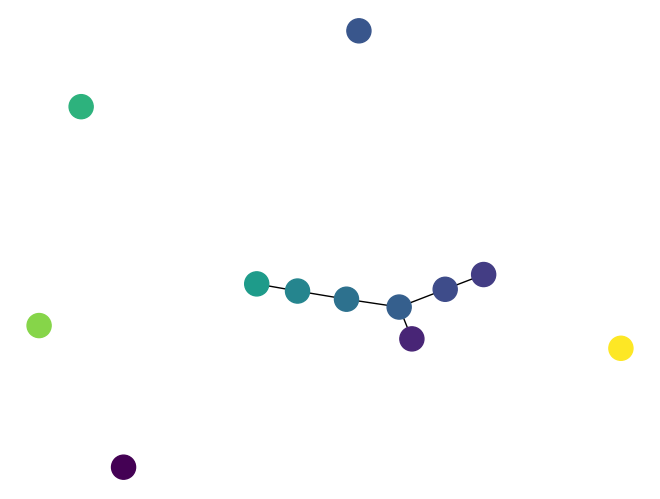

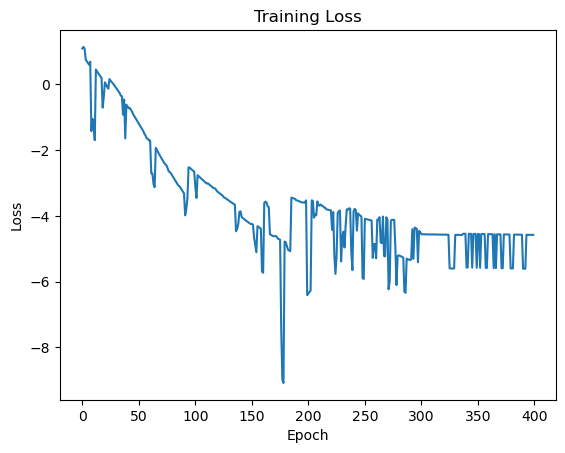

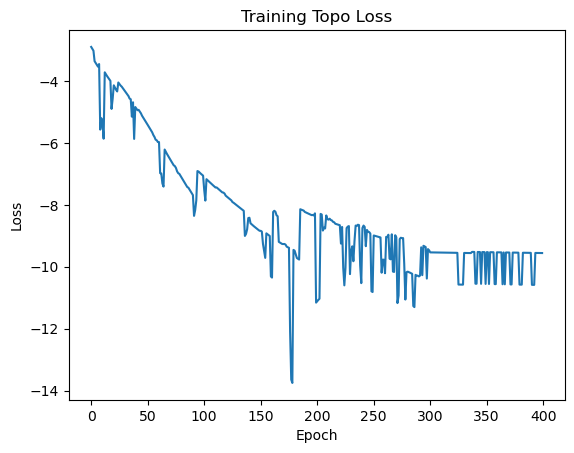

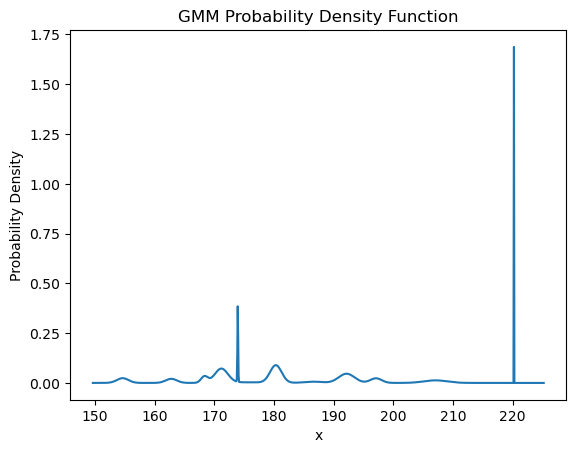

237
classtensor([11]) has no points!!!


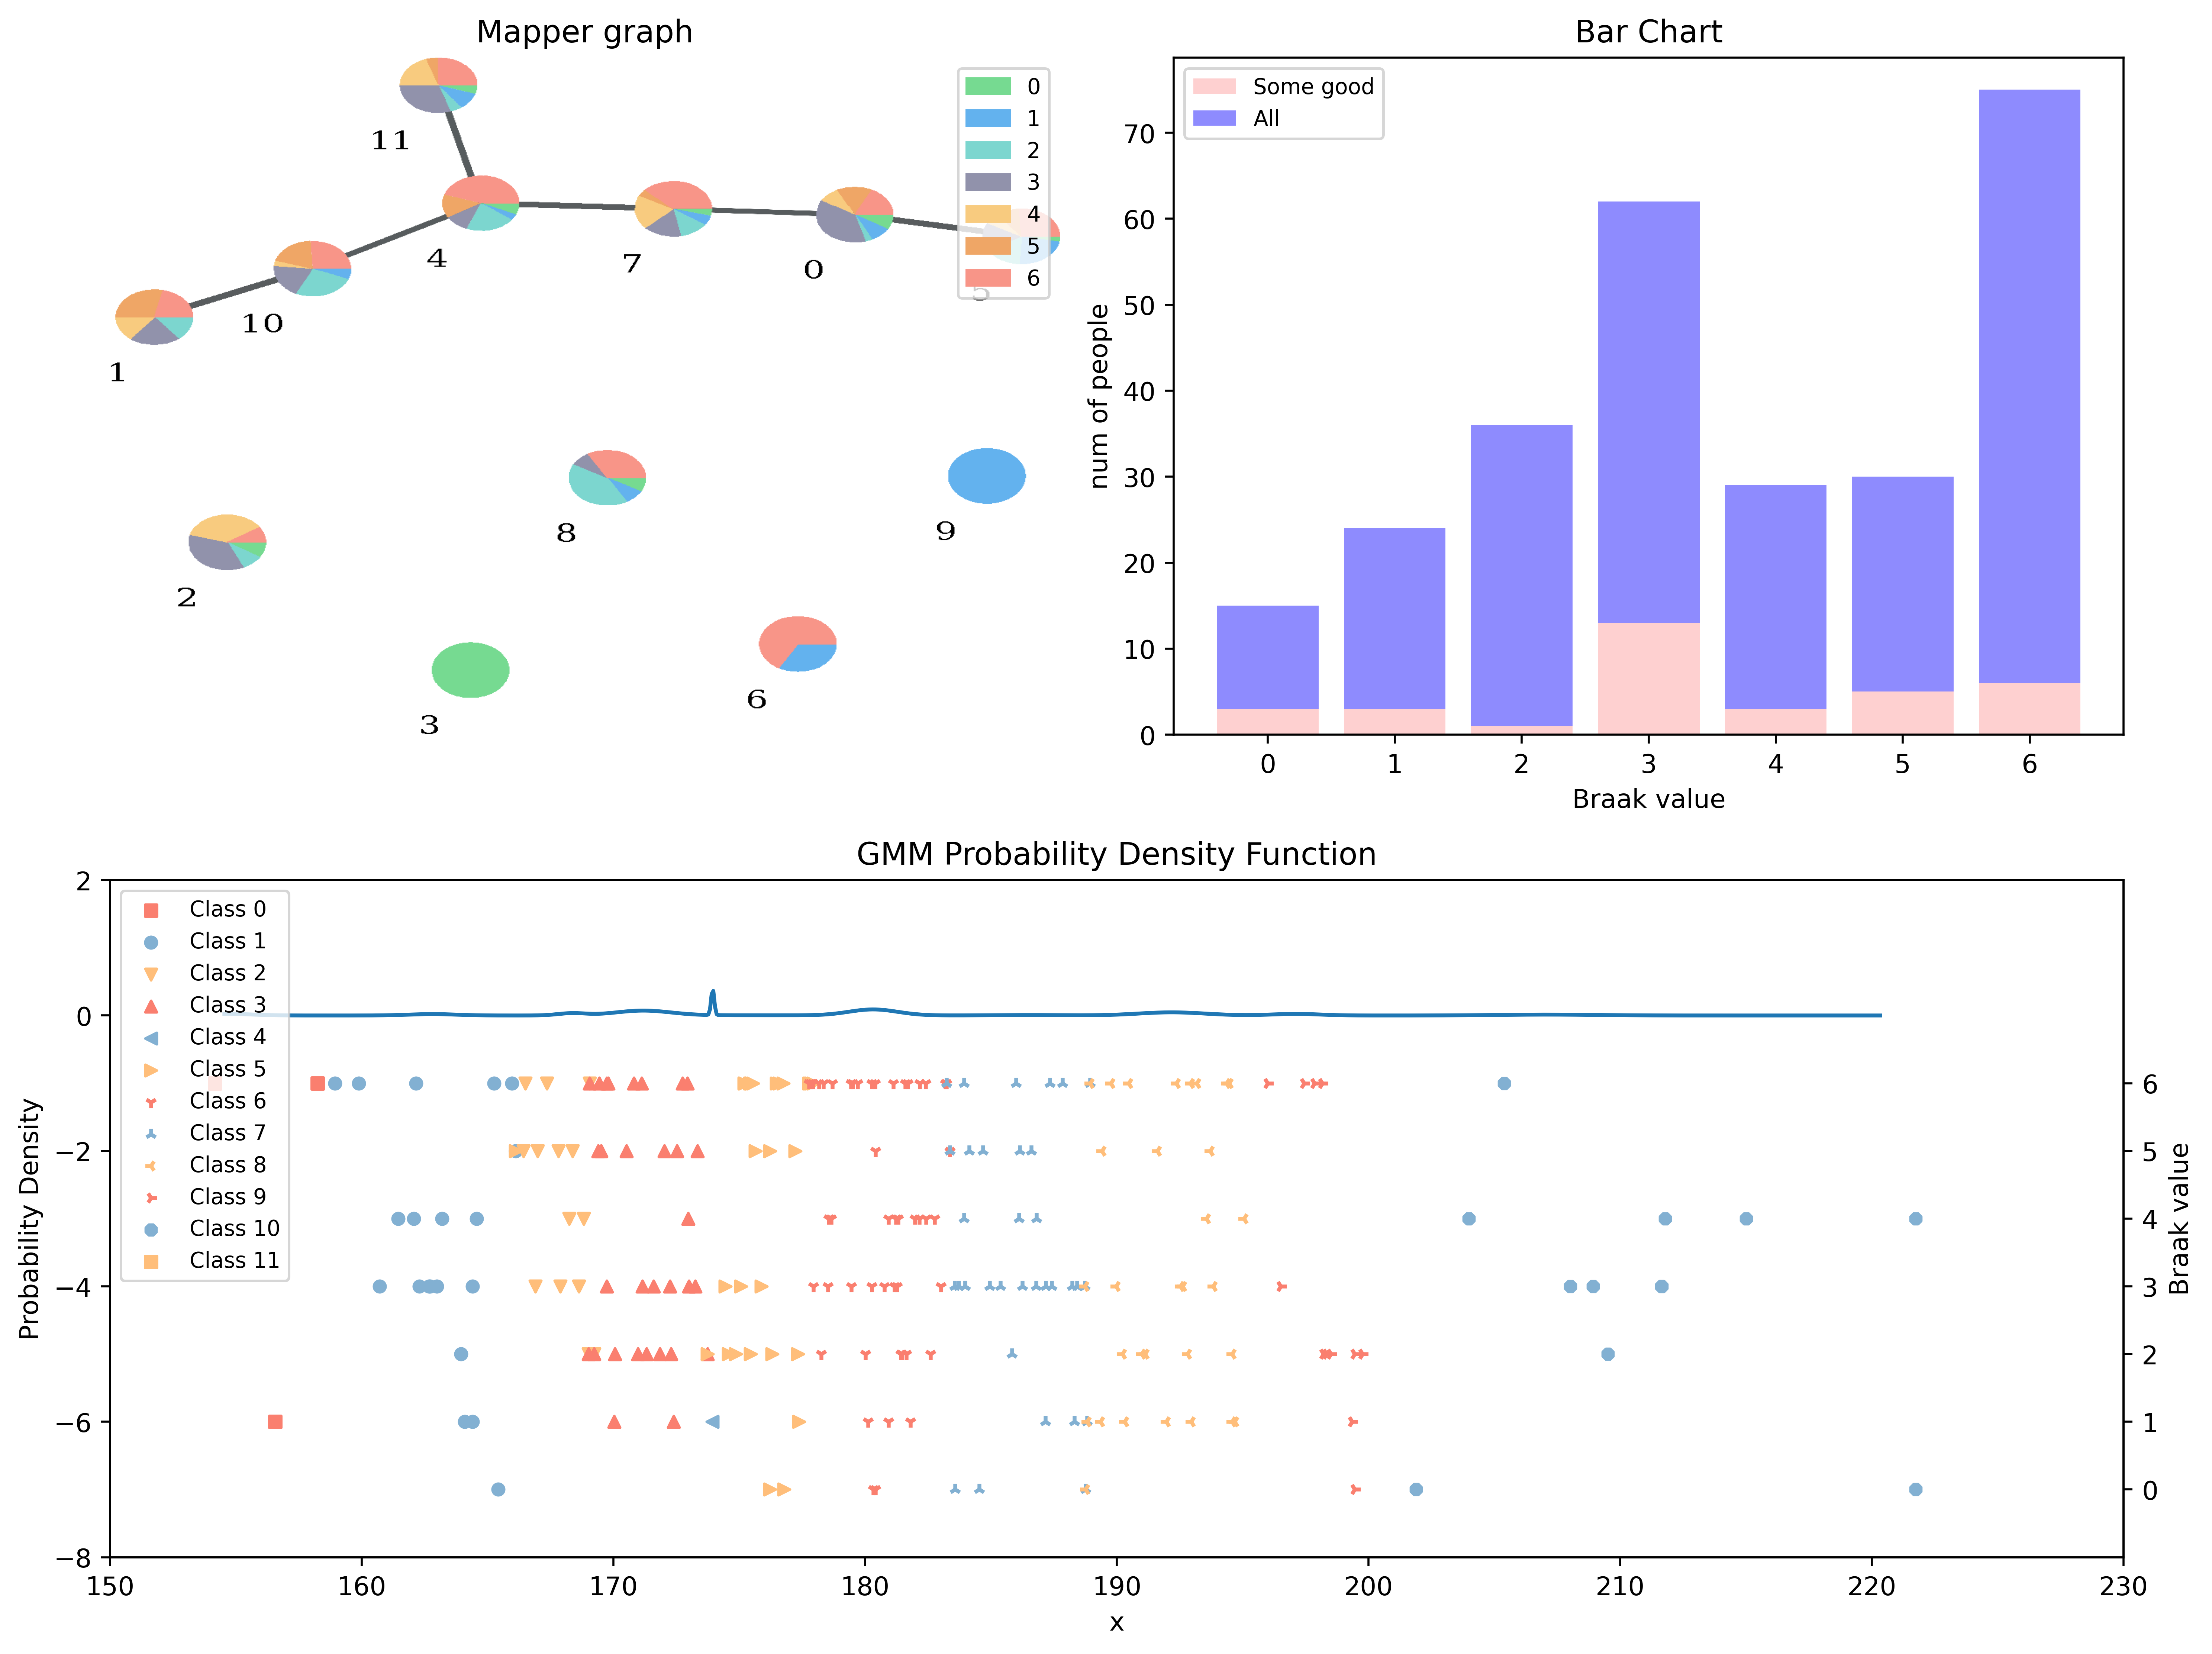

###########
KstestResult(statistic=0.8571428571428571, pvalue=0.008158508158508158, statistic_location=13.0, statistic_sign=1)
Have difference!!!


In [4]:
dis_matrix = distance.squareform(distance.pdist(data, metric="euclidean"))
dis_matrix = torch.tensor(dis_matrix)
projected_data = torch.max(dis_matrix,dim = 1)[0]
projected_data = projected_data.view(len(projected_data),1)

n_comp = 12
num_step = 400 
l1 = 1
l2 = 1

mapper = MapperComplex(
input_type="distance matrix",
resolutions=n_comp,
gains=None,
clustering=None,
)
mapper.fit(dis_matrix.numpy(), filters=projected_data.numpy(),colors=projected_data.numpy())

cl = mapper.clustering

# GMM initialization
gmm = GaussianMixture(n_components=n_comp, covariance_type='full', n_init = 10,
                      max_iter= 1000,tol=1e-6,random_state = 0 )
gmm.fit(projected_data)
init_mean = torch.tensor(gmm.means_).view(-1)
init_var = torch.tensor(gmm.covariances_).view(-1)
init_weights = torch.tensor(gmm.weights_).view(-1)

m = Opt_GMM_Mapper(n_comp, means = init_mean, covariances=init_var, weights=init_weights, type = "distance matrix")
m.draw()
init_scheme = m.forward(projected_data, dis_matrix, cl)

# mapper before optimization
mapper = Soft_Mapper.GMM_Soft_Mapper(init_scheme, cl, data = dis_matrix, projected_data =projected_data,path='figures'
                                     ,name = 'MSBB_44',format = 'eps',type="distance matrix")
G_mode = mapper.mode(save_fig= False)

optimizer = optim.Adam(m.parameters(), lr=0.005, betas=(0.9, 0.999), eps=1e-08, weight_decay=1)
scheduler = lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.01)

# train
train = Trainer(m, cl, num_step, optimizer, scheduler)
train.fit(dis_matrix, projected_data, l1, l2)
train.analysis()

# mapper after optimization
G_mode = train.G_mode
clusters = train.mode_clusters
good_nodes = [0] 
analysis_braak(G_mode, train, data_path, projected_data, good_nodes, (150,230),(-8, 2))

# 36 Hyperbolic

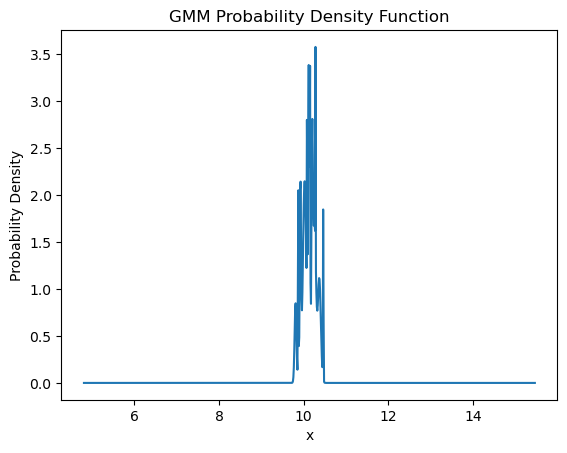

mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


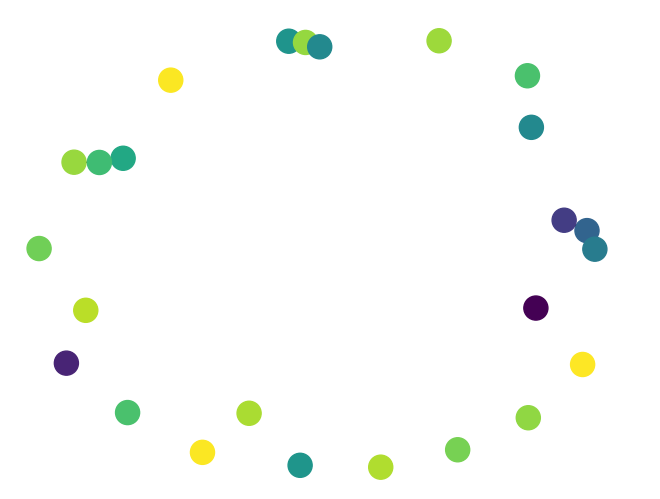

100%|██████████| 400/400 [00:07<00:00, 50.24it/s]


loss: -1365.6692664734205
topo_loss: -1409.1530410985877
mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


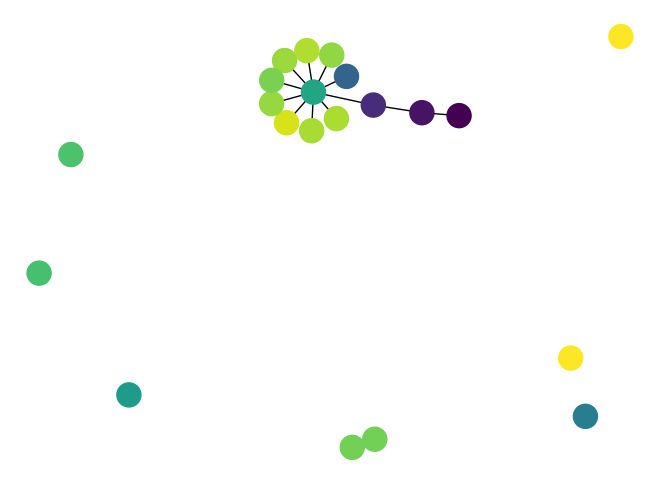

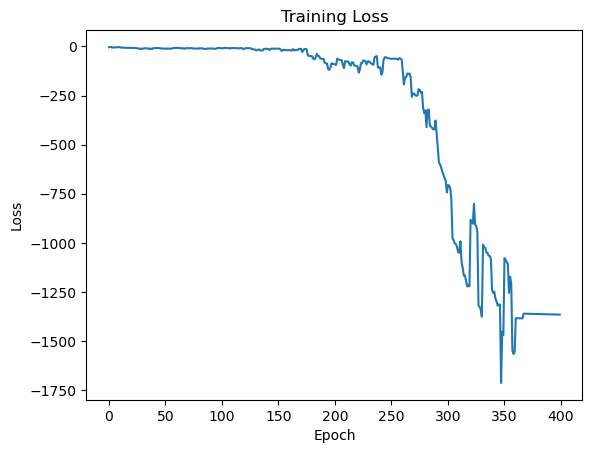

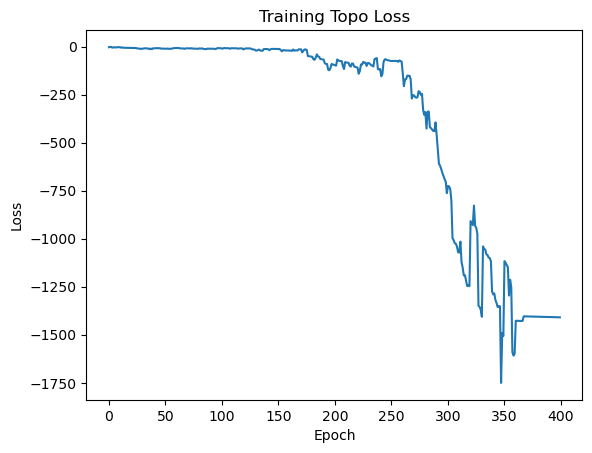

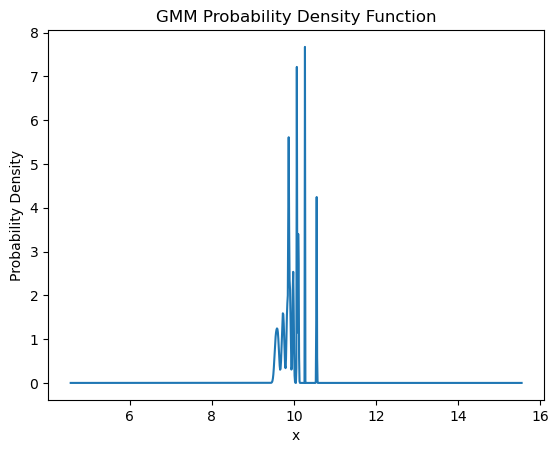

248
classtensor([0]) has no points!!!


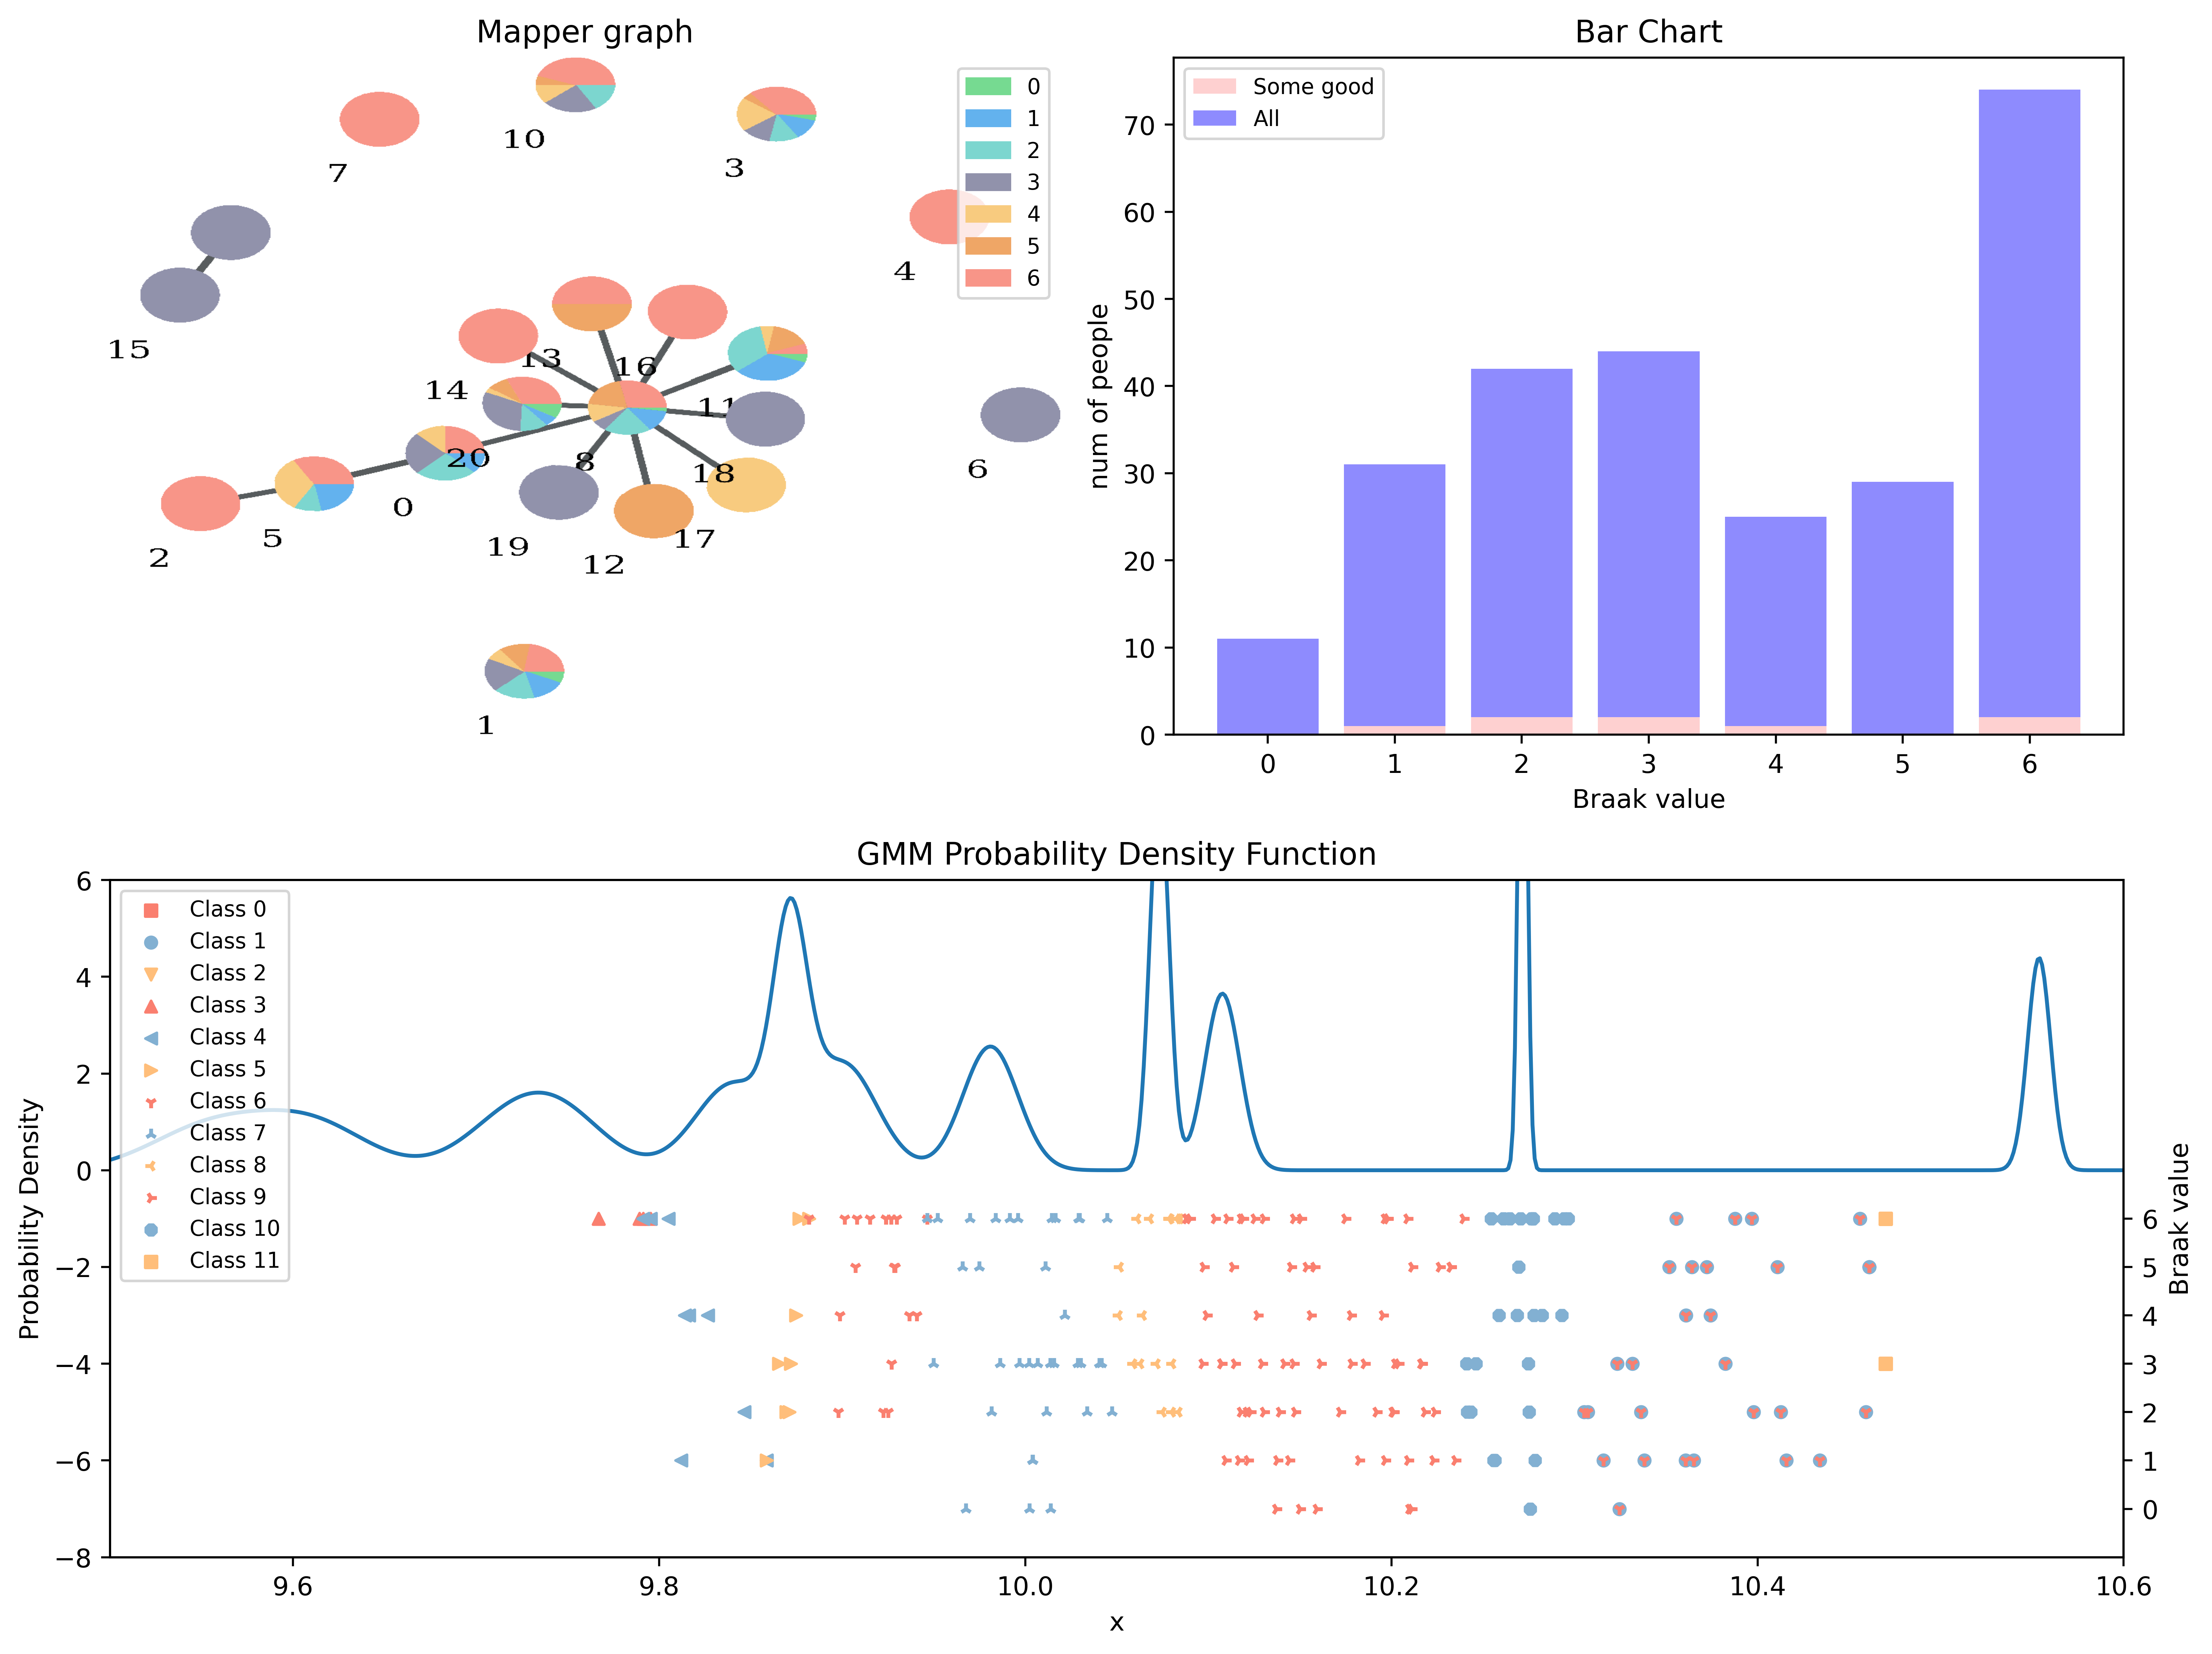

###########
KstestResult(statistic=1.0, pvalue=0.0005827505827505828, statistic_location=2.0, statistic_sign=1)
Have difference!!!


In [5]:
data_path = "data/36.csv"
df = pd.read_csv(data_path, index_col=0)
data = np.array(df)
data = torch.tensor(data,dtype=float)

dis_matrix = mean_lor_distance(data)
projected_data = torch.max(dis_matrix,dim = 1)[0]
projected_data = projected_data.view(len(projected_data),1)

n_comp = 12
num_step = 400 
l1 = 1
l2 = 1

mapper = MapperComplex(
input_type="distance matrix",
resolutions=n_comp,
gains=None,
clustering=None,
)
mapper.fit(dis_matrix.numpy(), filters=projected_data.numpy(),colors=projected_data.numpy())

cl = mapper.clustering

# GMM initialization
gmm = GaussianMixture(n_components=n_comp, covariance_type='full', n_init = 10,
                      max_iter= 1000,tol=1e-6,random_state = 0 )
gmm.fit(projected_data)
init_mean = torch.tensor(gmm.means_).view(-1)
init_var = torch.tensor(gmm.covariances_).view(-1)
init_weights = torch.tensor(gmm.weights_).view(-1)

m = Opt_GMM_Mapper(n_comp, means = init_mean, covariances=init_var, weights=init_weights, type = "distance matrix")
m.draw()
init_scheme = m.forward(projected_data, dis_matrix, cl)

# mapper before optimization
mapper = Soft_Mapper.GMM_Soft_Mapper(init_scheme, cl, data = dis_matrix, projected_data =projected_data,path='figures'
                                     ,name = 'MSBB_44',format = 'eps',type="distance matrix")
G_mode = mapper.mode(save_fig= False)

optimizer = optim.Adam(m.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1)
scheduler = lr_scheduler.StepLR(optimizer, step_size=360, gamma=0.01)

# train
train = Trainer(m, cl, num_step, optimizer, scheduler)
train.fit(dis_matrix, projected_data, l1, l2)
train.analysis()

# mapper after optimization
G_mode = train.G_mode
clusters = train.mode_clusters
good_nodes = [0] 
analysis_braak(G_mode, train, data_path, projected_data, good_nodes, (9.5,10.6),(-8, 6))

# 36 Euclid

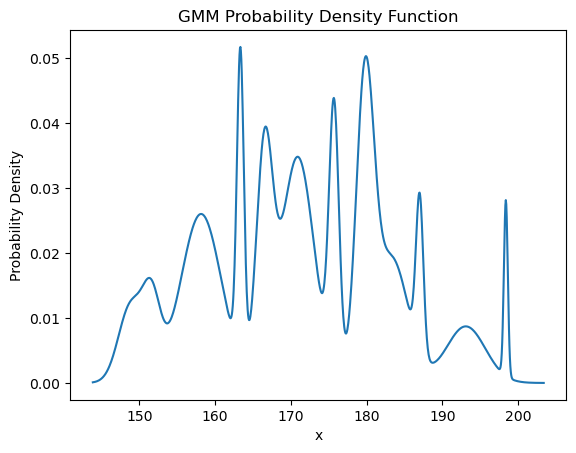

mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


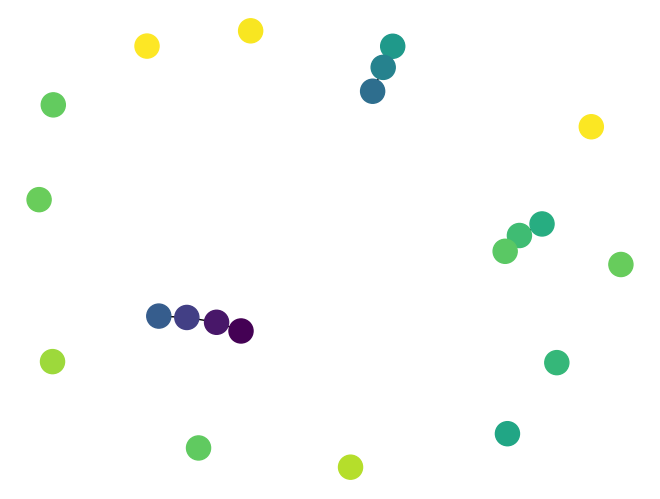

100%|██████████| 400/400 [00:06<00:00, 58.34it/s]


loss: -9.494640876264981
topo_loss: -14.11060806719386
mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


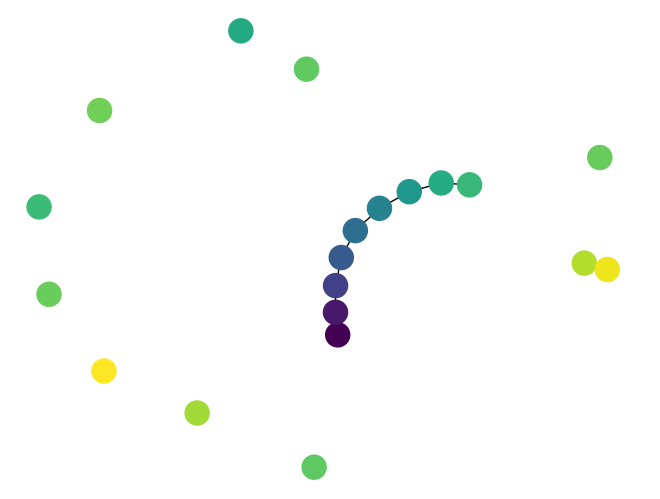

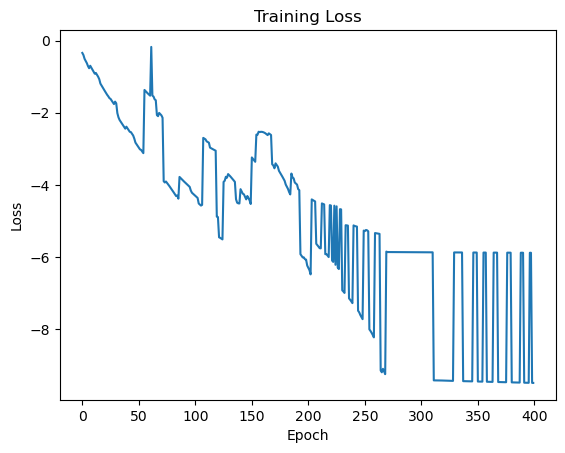

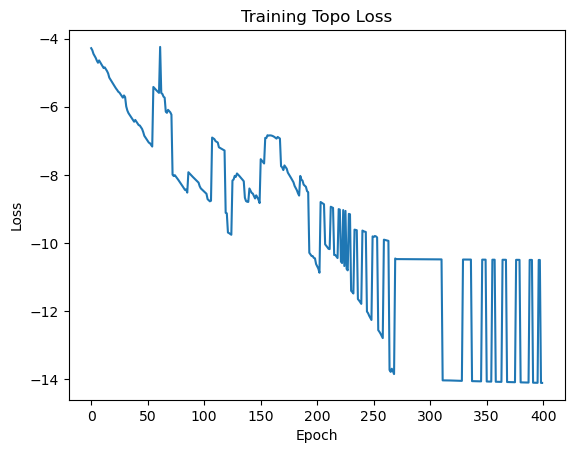

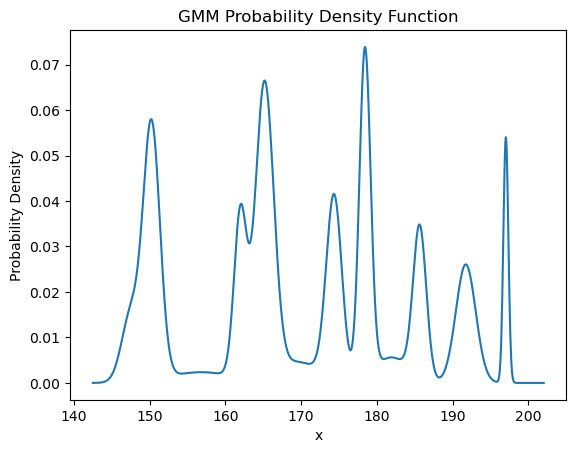

240


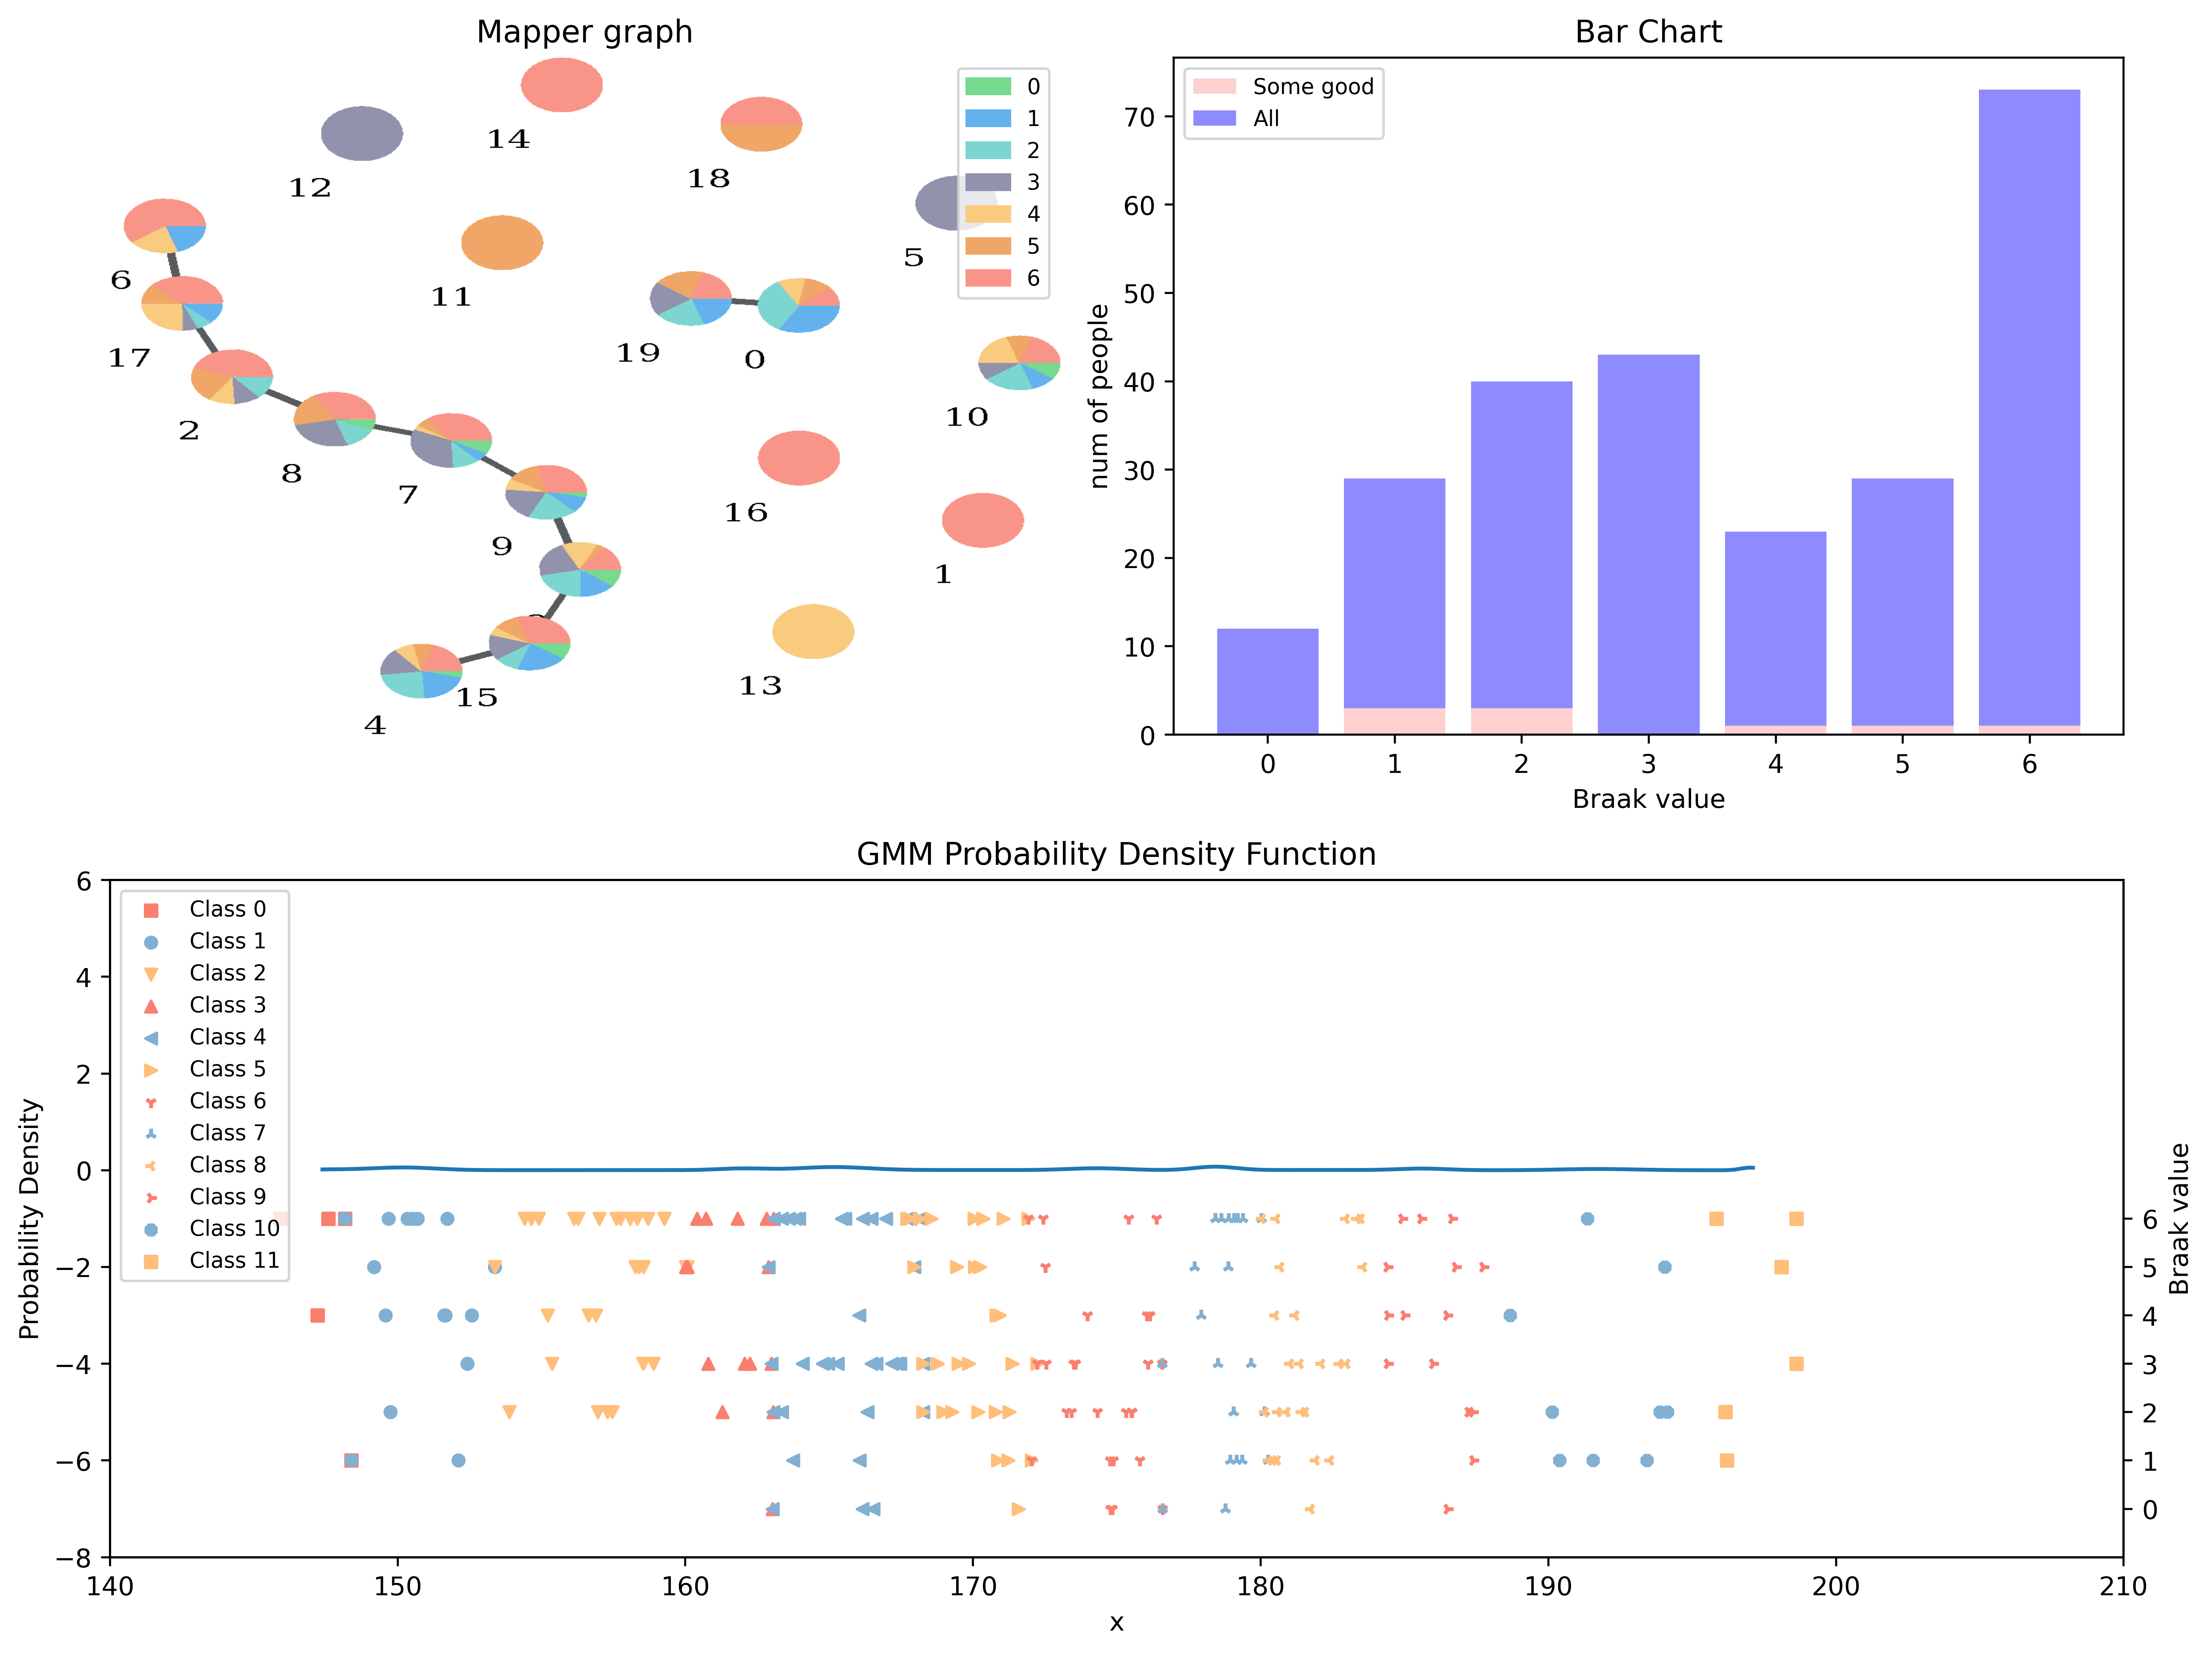

###########
KstestResult(statistic=1.0, pvalue=0.0005827505827505828, statistic_location=3.0, statistic_sign=1)
Have difference!!!


In [6]:
dis_matrix = distance.squareform(distance.pdist(data, metric="euclidean"))
dis_matrix = torch.tensor(dis_matrix)
projected_data = torch.max(dis_matrix,dim = 1)[0]
projected_data = projected_data.view(len(projected_data),1)

n_comp = 12
num_step = 400 
l1 = 1
l2 = 1

mapper = MapperComplex(
input_type="distance matrix",
resolutions=n_comp,
gains=None,
clustering=None,
)
mapper.fit(dis_matrix.numpy(), filters=projected_data.numpy(),colors=projected_data.numpy())

cl = mapper.clustering

# GMM initialization
gmm = GaussianMixture(n_components=n_comp, covariance_type='full', n_init = 10,
                      max_iter= 1000,tol=1e-6,random_state = 0 )
gmm.fit(projected_data)
init_mean = torch.tensor(gmm.means_).view(-1)
init_var = torch.tensor(gmm.covariances_).view(-1)
init_weights = torch.tensor(gmm.weights_).view(-1)

m = Opt_GMM_Mapper(n_comp, means = init_mean, covariances=init_var, weights=init_weights, type = "distance matrix")
m.draw()
init_scheme = m.forward(projected_data, dis_matrix, cl)

# mapper before optimization
mapper = Soft_Mapper.GMM_Soft_Mapper(init_scheme, cl, data = dis_matrix, projected_data =projected_data,path='figures'
                                     ,name = 'MSBB_44',format = 'eps',type="distance matrix")
G_mode = mapper.mode(save_fig= False)

optimizer = optim.Adam(m.parameters(), lr=0.005, betas=(0.9, 0.999), eps=1e-08, weight_decay=1)
scheduler = lr_scheduler.StepLR(optimizer, step_size=270, gamma=0.01)

# train
train = Trainer(m, cl, num_step, optimizer, scheduler)
train.fit(dis_matrix, projected_data, l1, l2)
train.analysis()

# mapper after optimization
G_mode = train.G_mode
clusters = train.mode_clusters
good_nodes = [0] 
analysis_braak(G_mode, train, data_path, projected_data, good_nodes, (140,210),(-8, 6))

# 22 Hyperbolic

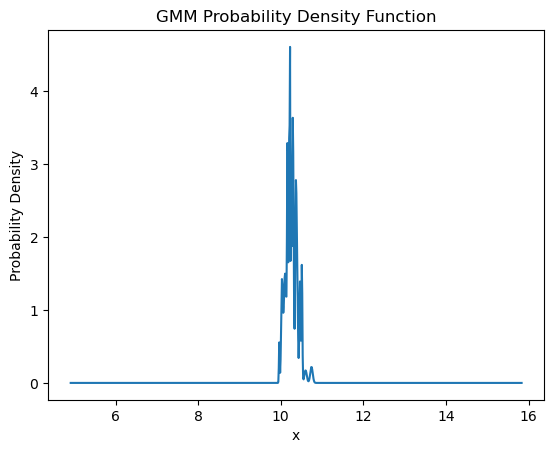

mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


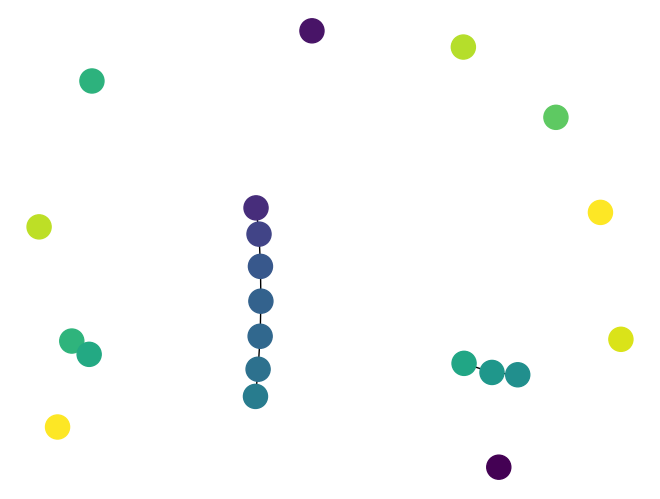

100%|██████████| 400/400 [00:08<00:00, 45.80it/s]


loss: -51.87870898589529
topo_loss: -187.6288840727117
mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


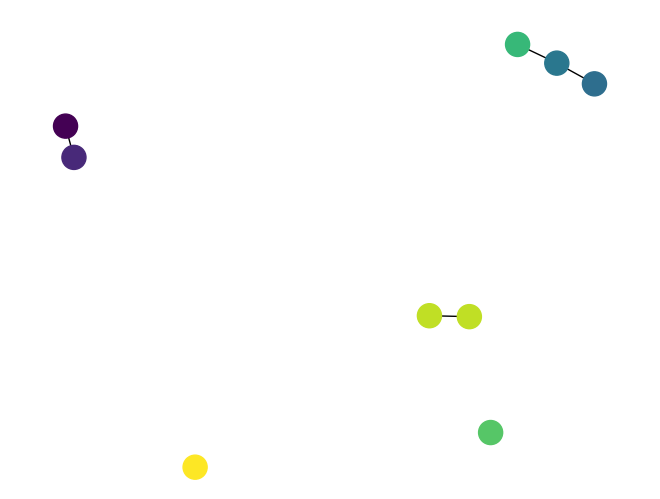

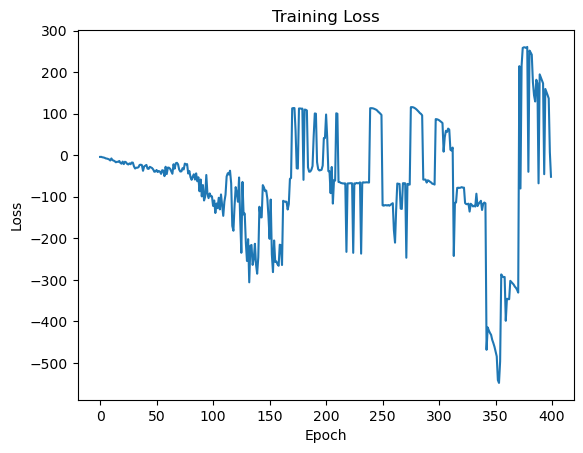

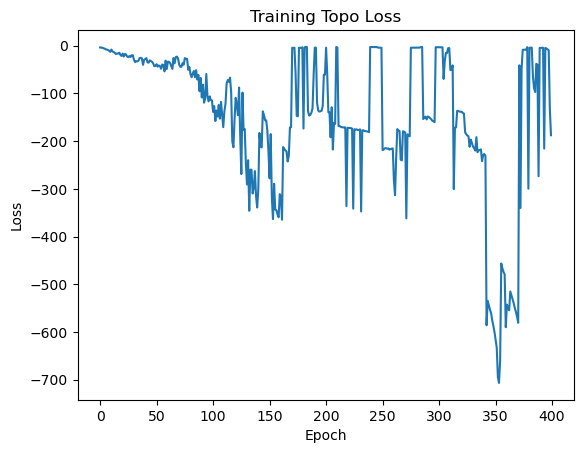

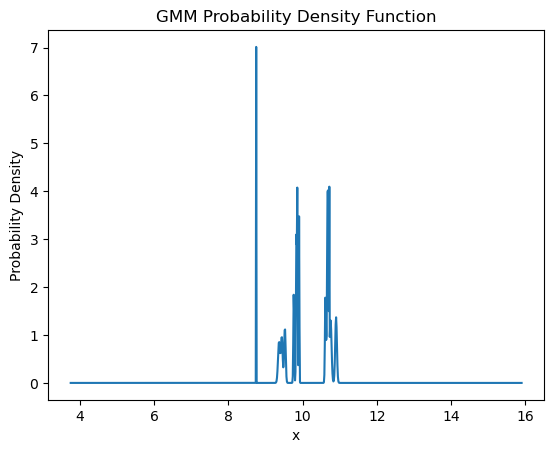

409
classtensor([0]) has no points!!!


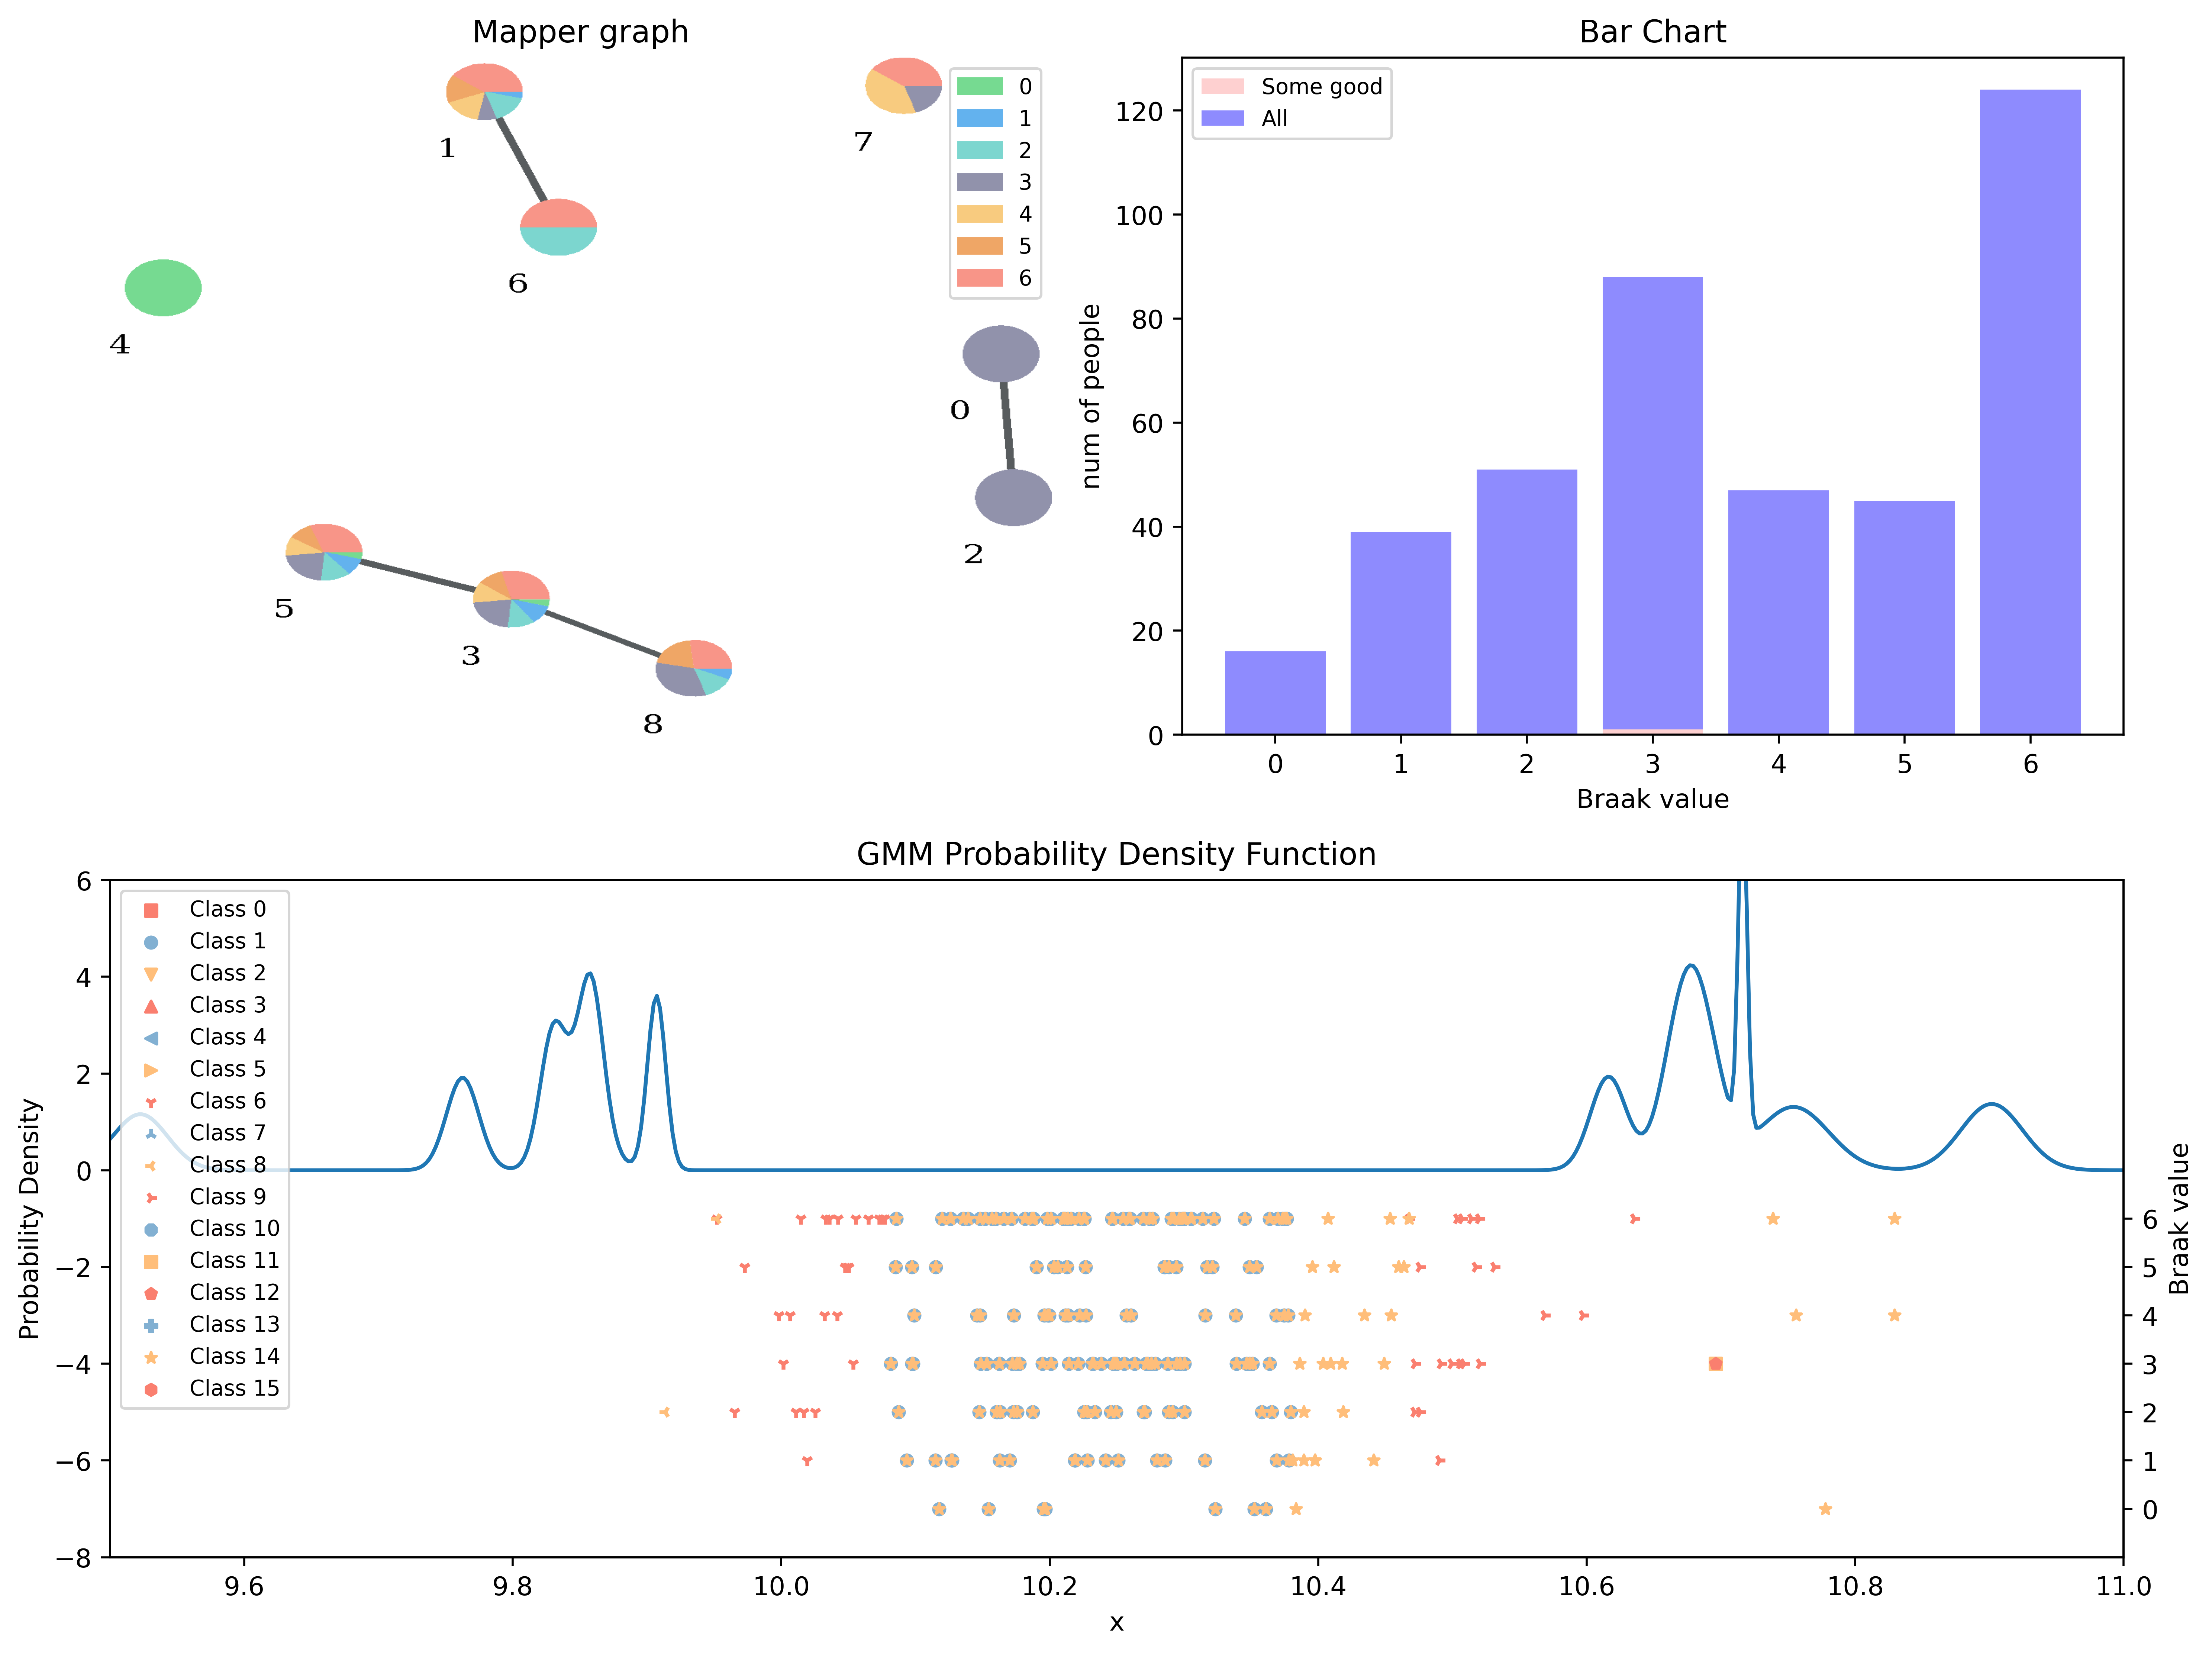

###########
KstestResult(statistic=1.0, pvalue=0.0005827505827505828, statistic_location=1.0, statistic_sign=1)
Have difference!!!


In [7]:
data_path = "data/22.csv"
df = pd.read_csv(data_path, index_col=0)
data = np.array(df)
data = torch.tensor(data,dtype=float)

dis_matrix = mean_lor_distance(data)
projected_data = torch.max(dis_matrix,dim = 1)[0]
projected_data = projected_data.view(len(projected_data),1)

n_comp = 16
num_step = 400 
l1 = 1
l2 = 1

mapper = MapperComplex(
input_type="distance matrix",
resolutions=n_comp,
gains=None,
clustering=None,
)
mapper.fit(dis_matrix.numpy(), filters=projected_data.numpy(),colors=projected_data.numpy())

cl = mapper.clustering

# GMM initialization
gmm = GaussianMixture(n_components=n_comp, covariance_type='full', n_init = 10,
                      max_iter= 1000,tol=1e-6,random_state = 0 )
gmm.fit(projected_data)
init_mean = torch.tensor(gmm.means_).view(-1)
init_var = torch.tensor(gmm.covariances_).view(-1)
init_weights = torch.tensor(gmm.weights_).view(-1)

m = Opt_GMM_Mapper(n_comp, means = init_mean, covariances=init_var, weights=init_weights, type = "distance matrix")
m.draw()
init_scheme = m.forward(projected_data, dis_matrix, cl)

# mapper before optimization
mapper = Soft_Mapper.GMM_Soft_Mapper(init_scheme, cl, data = dis_matrix, projected_data =projected_data,path='figures'
                                     ,name = 'MSBB_44',format = 'eps',type="distance matrix")
G_mode = mapper.mode(save_fig= False)

optimizer = optim.Adam(m.parameters(), lr=0.003, betas=(0.9, 0.999), eps=1e-08, weight_decay=1)
scheduler = lr_scheduler.StepLR(optimizer, step_size=350, gamma=0.01)

# train
train = Trainer(m, cl, num_step, optimizer, scheduler)
train.fit(dis_matrix, projected_data, l1, l2)
train.analysis()

# mapper after optimization
G_mode = train.G_mode
clusters = train.mode_clusters
good_nodes = [0] 
analysis_braak(G_mode, train, data_path, projected_data, good_nodes, (9.5,11),(-8, 6))

# 22 Euclid

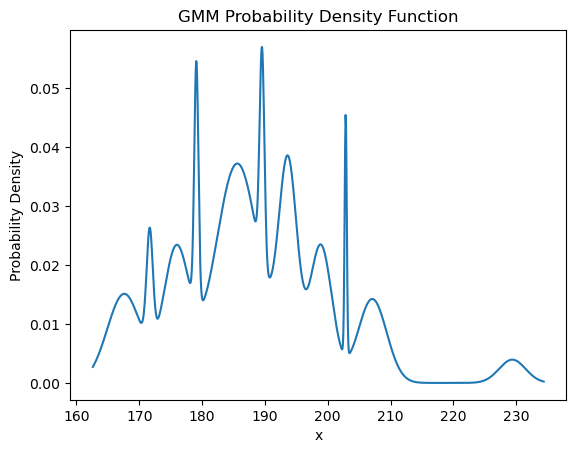

mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


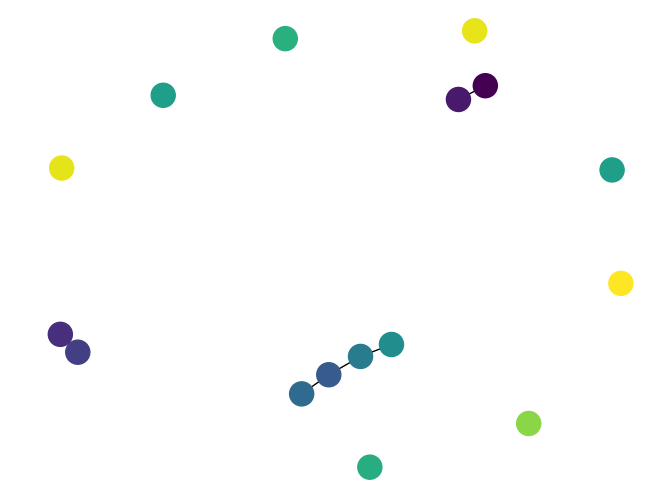

100%|██████████| 400/400 [00:06<00:00, 59.48it/s]

loss: -0.643049595313772
topo_loss: -5.237111677424832
mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


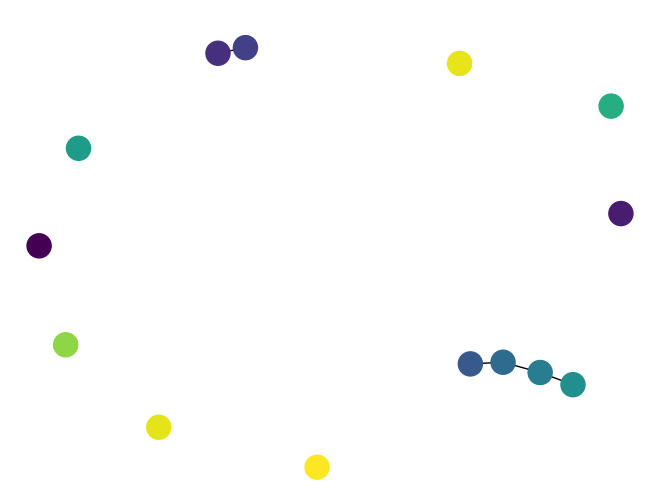

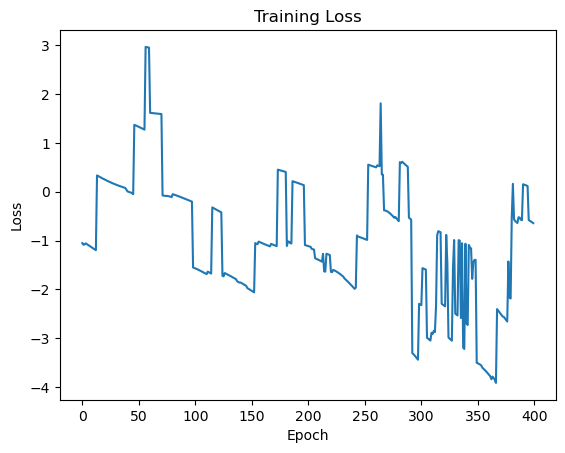

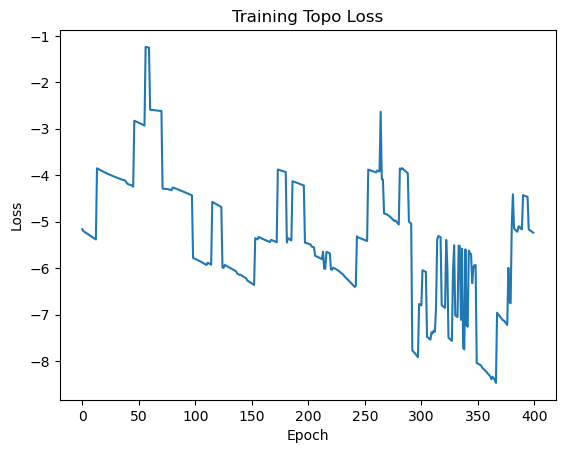

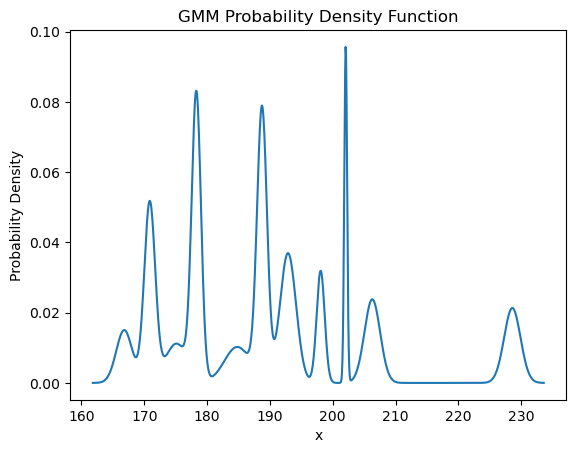

248
classtensor([10]) has no points!!!


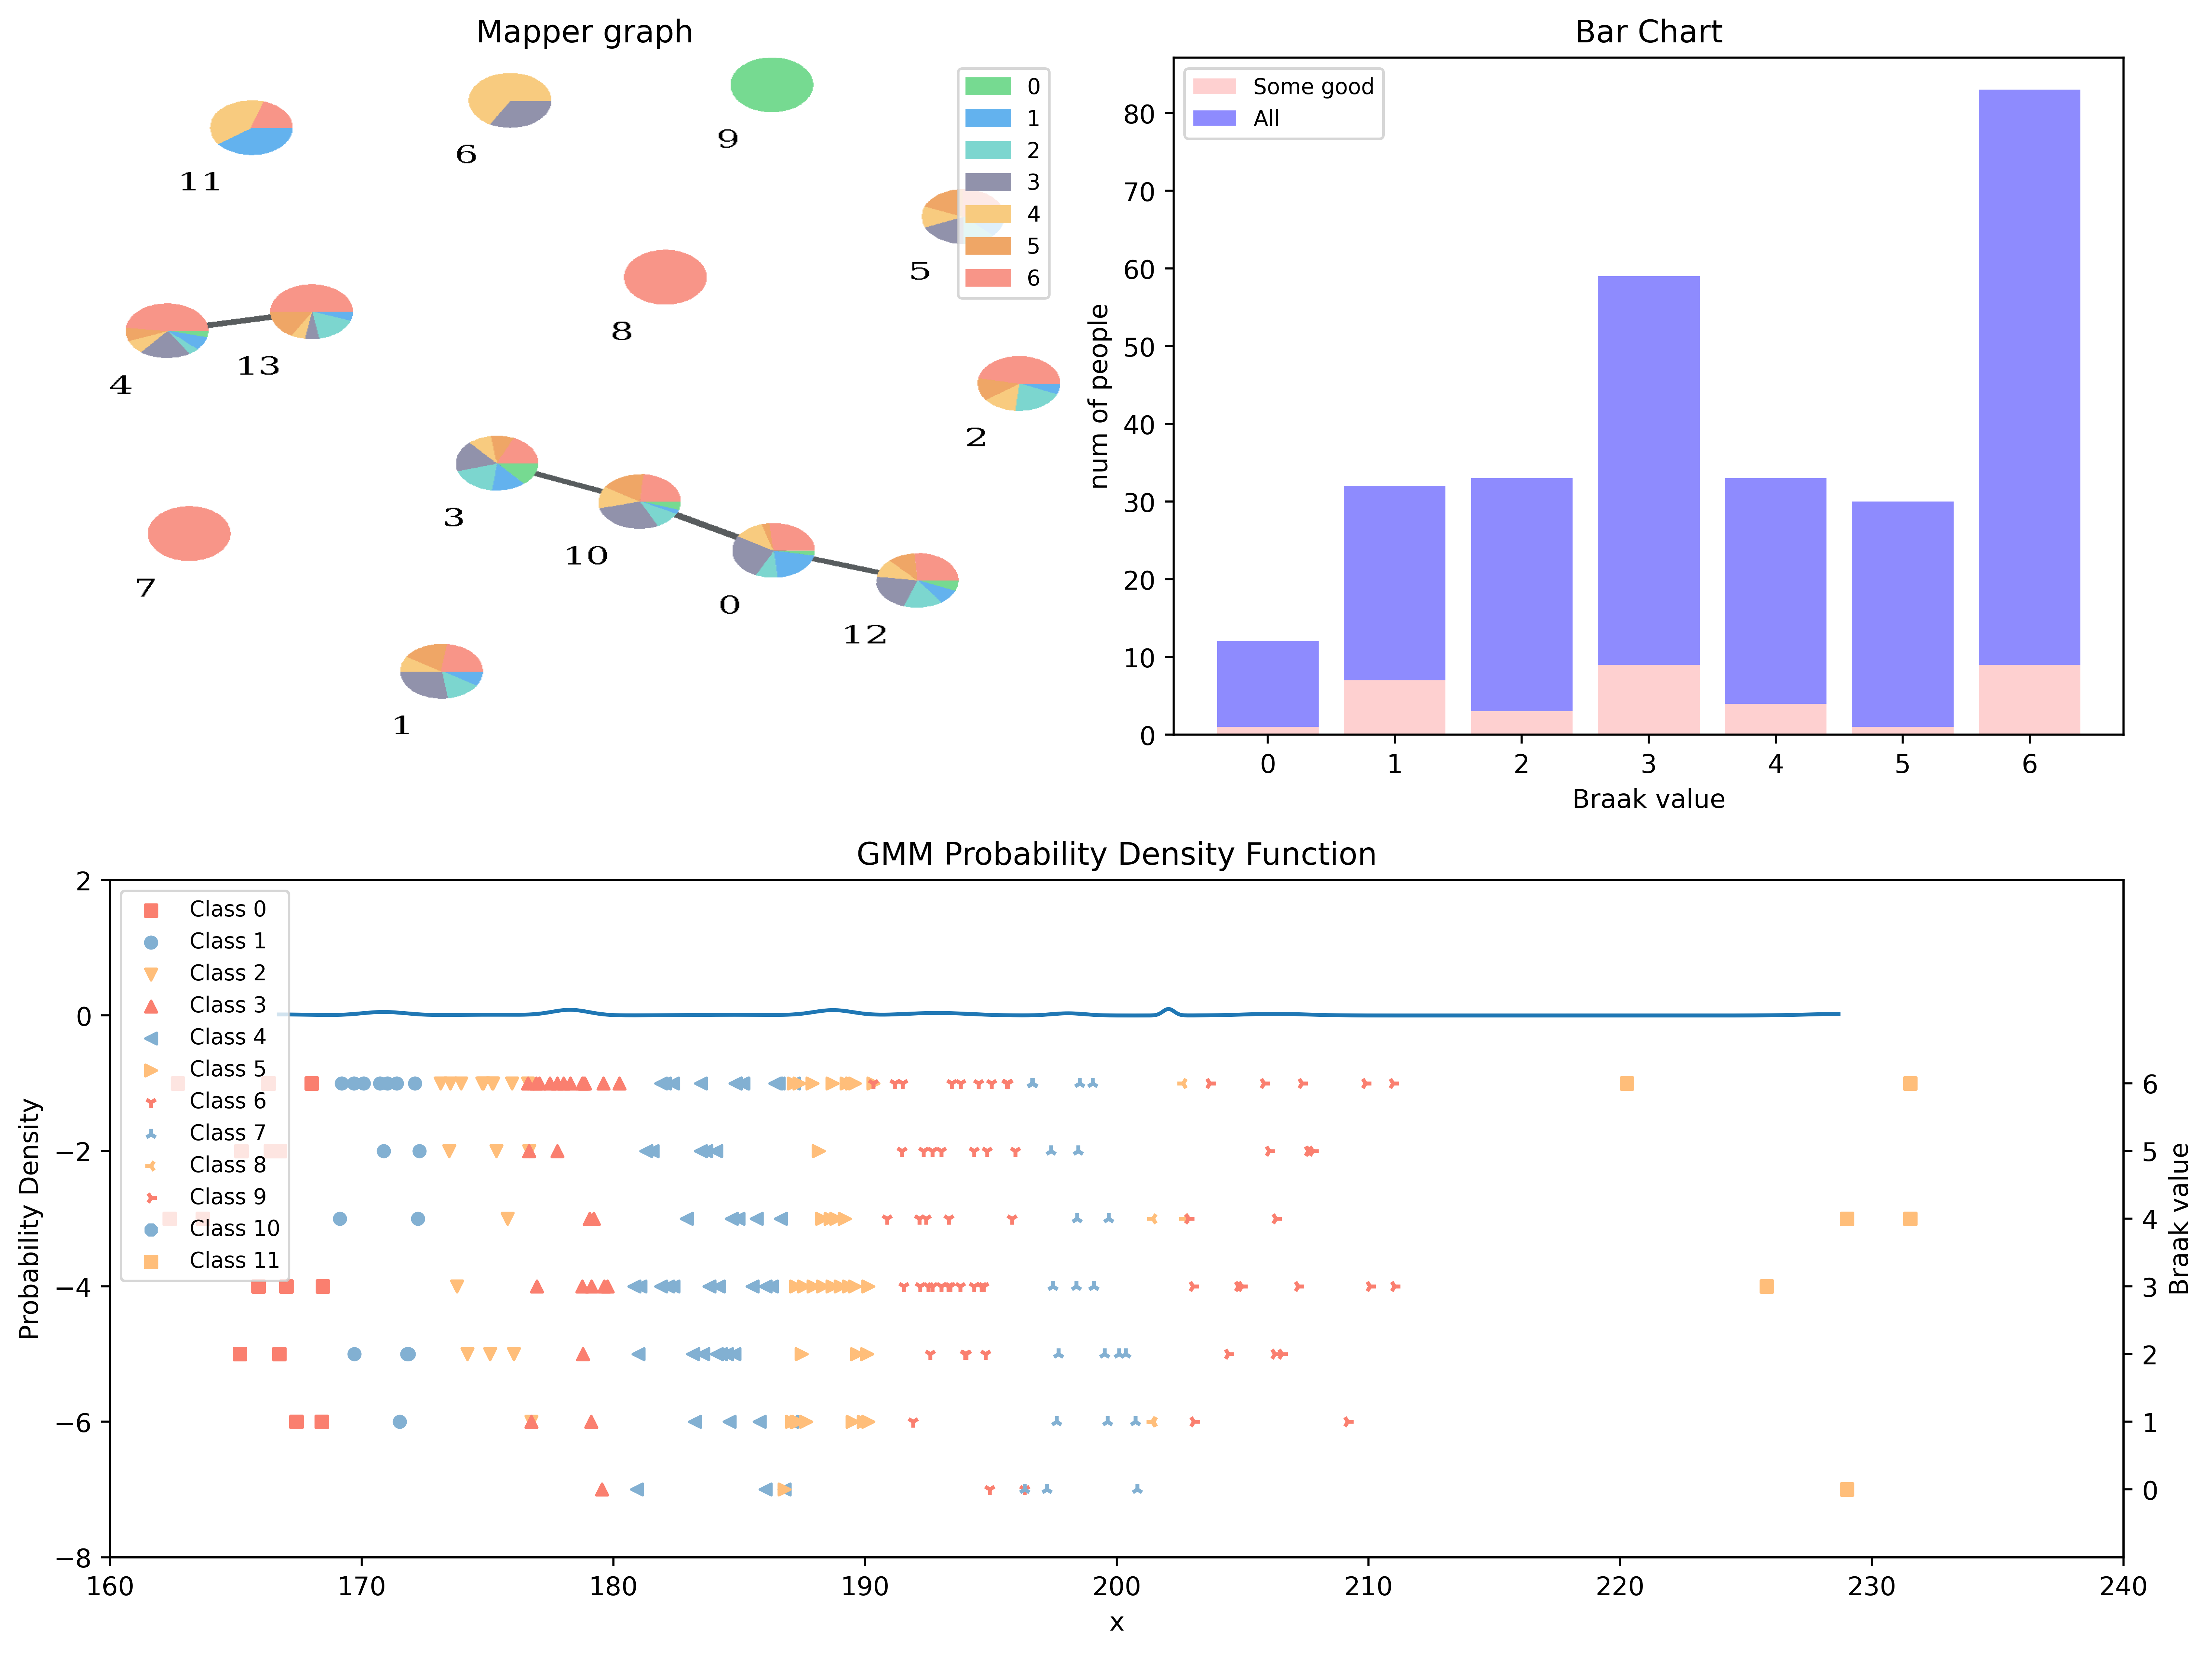

###########
KstestResult(statistic=1.0, pvalue=0.0005827505827505828, statistic_location=9.0, statistic_sign=1)
Have difference!!!


In [8]:
dis_matrix = distance.squareform(distance.pdist(data, metric="euclidean"))
dis_matrix = torch.tensor(dis_matrix)
projected_data = torch.max(dis_matrix,dim = 1)[0]
projected_data = projected_data.view(len(projected_data),1)

n_comp = 12
num_step = 400 
l1 = 1
l2 = 1

mapper = MapperComplex(
input_type="distance matrix",
resolutions=n_comp,
gains=None,
clustering=None,
)
mapper.fit(dis_matrix.numpy(), filters=projected_data.numpy(),colors=projected_data.numpy())

cl = mapper.clustering

# GMM initialization
gmm = GaussianMixture(n_components=n_comp, covariance_type='full', n_init = 10,
                      max_iter= 1000,tol=1e-6,random_state = 0 )
gmm.fit(projected_data)
init_mean = torch.tensor(gmm.means_).view(-1)
init_var = torch.tensor(gmm.covariances_).view(-1)
init_weights = torch.tensor(gmm.weights_).view(-1)

m = Opt_GMM_Mapper(n_comp, means = init_mean, covariances=init_var, weights=init_weights, type = "distance matrix")
m.draw()
init_scheme = m.forward(projected_data, dis_matrix, cl)

# mapper before optimization
mapper = Soft_Mapper.GMM_Soft_Mapper(init_scheme, cl, data = dis_matrix, projected_data =projected_data,path='figures'
                                     ,name = 'MSBB_44',format = 'eps',type="distance matrix")
G_mode = mapper.mode(save_fig= False)

optimizer = optim.Adam(m.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=1)
scheduler = lr_scheduler.StepLR(optimizer, step_size=400, gamma=0.01)

# train
train = Trainer(m, cl, num_step, optimizer, scheduler)
train.fit(dis_matrix, projected_data, l1, l2)
train.analysis()

# mapper after optimization
G_mode = train.G_mode
clusters = train.mode_clusters
good_nodes = [0] 
analysis_braak(G_mode, train, data_path, projected_data, good_nodes, (160,240),(-8, 2))

# 10 Hyperbolic

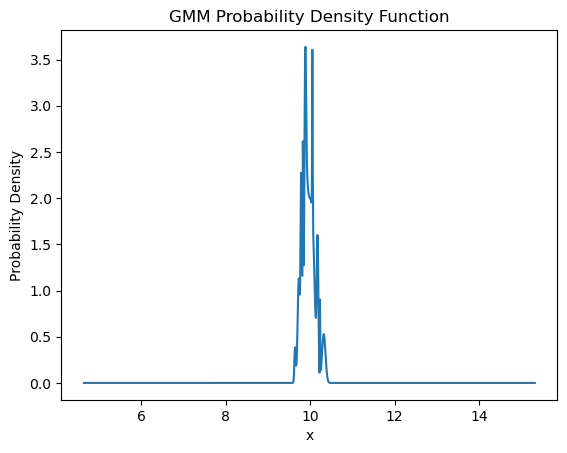

mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


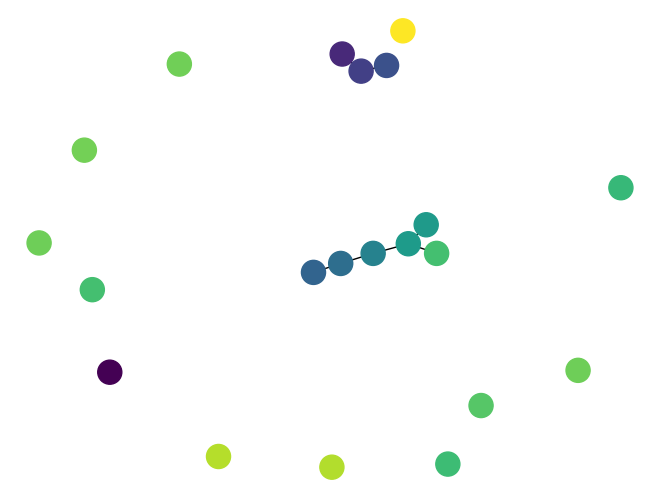

100%|██████████| 500/500 [00:10<00:00, 48.66it/s]

loss: -668.0500447585032
topo_loss: -717.1641031046357
mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


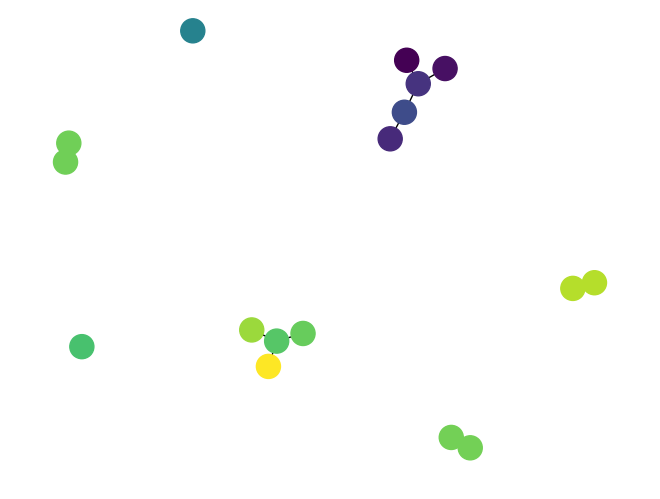

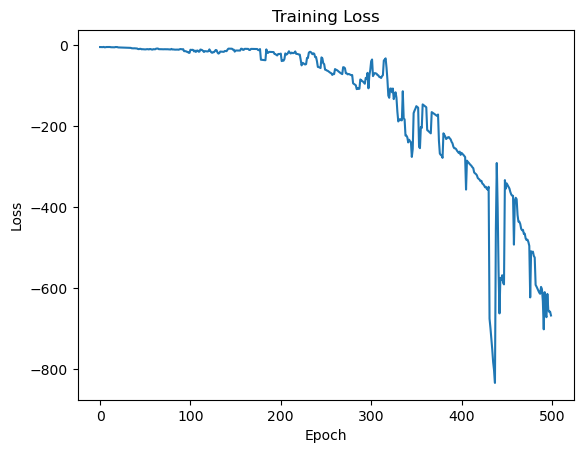

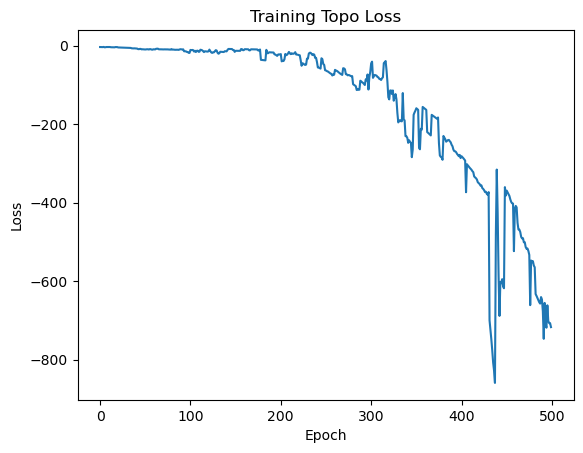

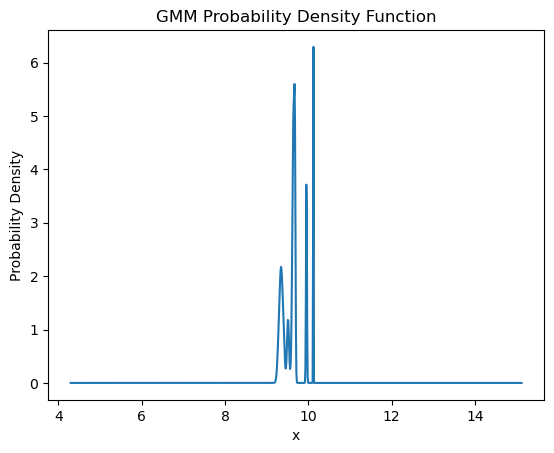

295
classtensor([0]) has no points!!!


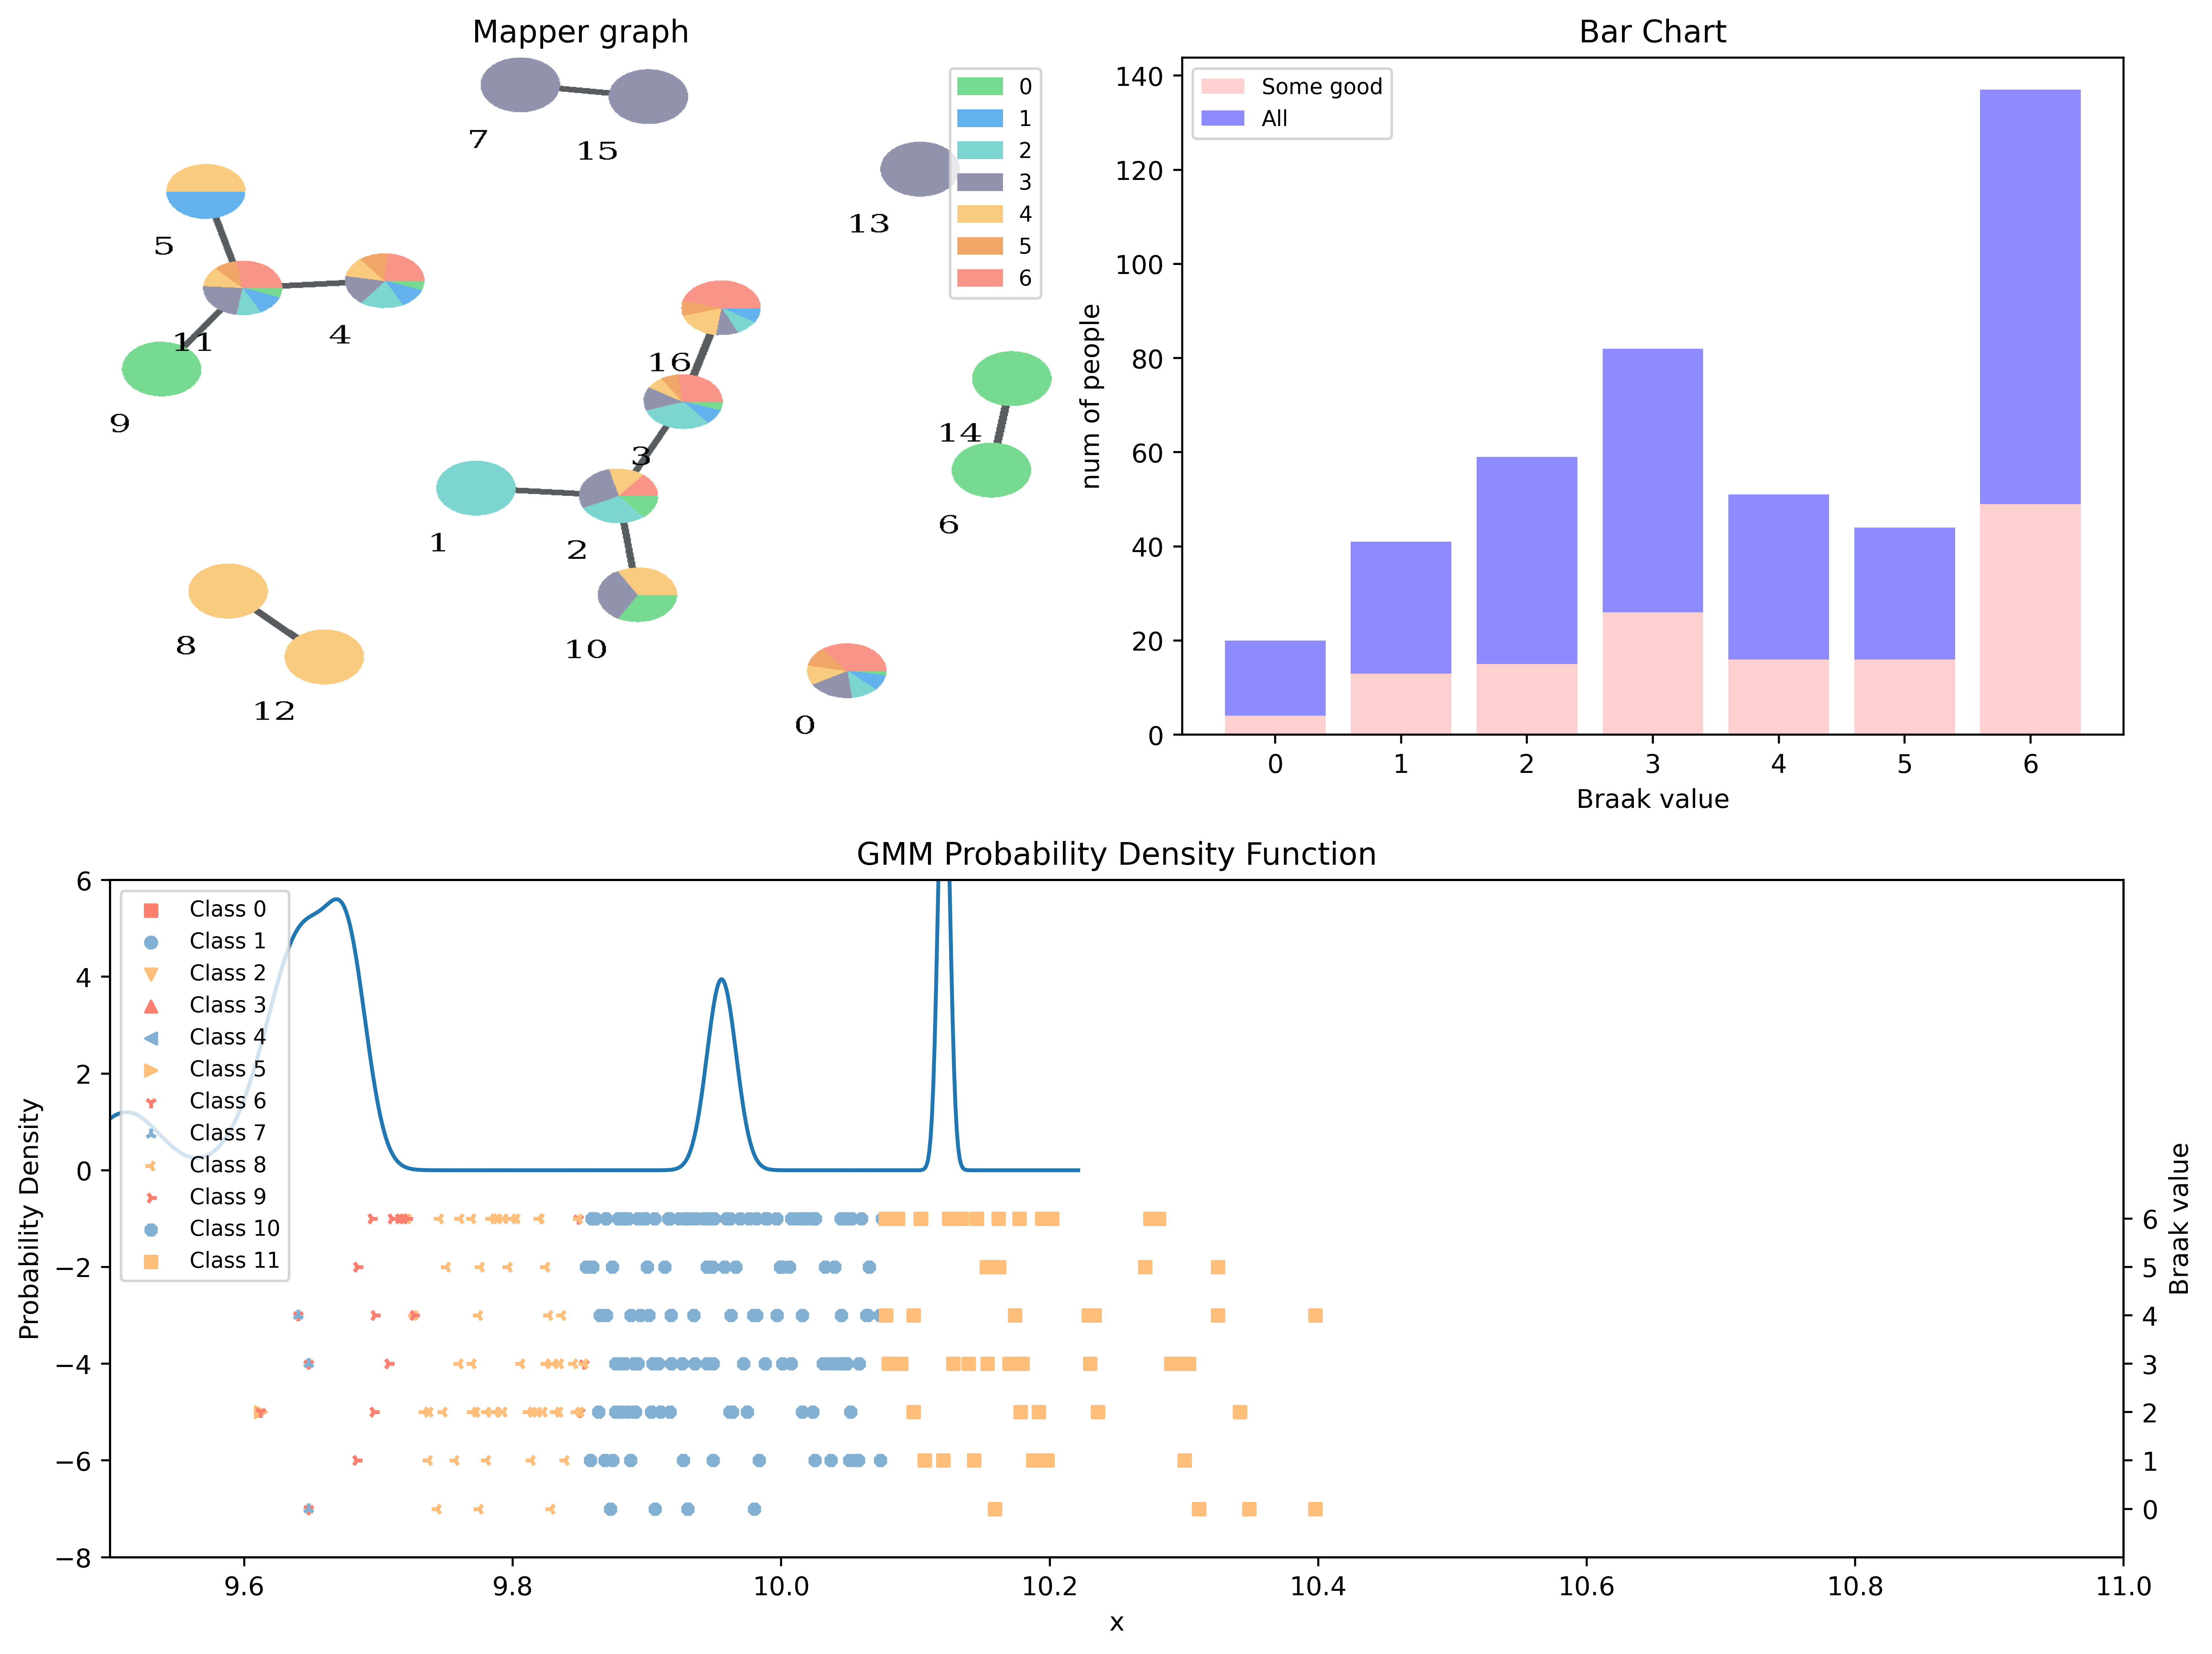

###########
KstestResult(statistic=0.7142857142857143, pvalue=0.05303030303030303, statistic_location=26.0, statistic_sign=1)
Have difference!!!


In [9]:
data_path = "data/10.csv"
df = pd.read_csv(data_path, index_col=0)
data = np.array(df)
data = torch.tensor(data,dtype=float)

dis_matrix = mean_lor_distance(data)
projected_data = torch.max(dis_matrix,dim = 1)[0]
projected_data = projected_data.view(len(projected_data),1)

n_comp = 12
num_step = 500 
l1 = 1
l2 = 1

mapper = MapperComplex(
input_type="distance matrix",
resolutions=n_comp,
gains=None,
clustering=None,
)
mapper.fit(dis_matrix.numpy(), filters=projected_data.numpy(),colors=projected_data.numpy())

cl = mapper.clustering

# GMM initialization
gmm = GaussianMixture(n_components=n_comp, covariance_type='full', n_init = 10,
                      max_iter= 1000,tol=1e-6,random_state = 0 )
gmm.fit(projected_data)
init_mean = torch.tensor(gmm.means_).view(-1)
init_var = torch.tensor(gmm.covariances_).view(-1)
init_weights = torch.tensor(gmm.weights_).view(-1)

m = Opt_GMM_Mapper(n_comp, means = init_mean, covariances=init_var, weights=init_weights, type = "distance matrix")
m.draw()
init_scheme = m.forward(projected_data, dis_matrix, cl)

# mapper before optimization
mapper = Soft_Mapper.GMM_Soft_Mapper(init_scheme, cl, data = dis_matrix, projected_data =projected_data,path='figures'
                                     ,name = 'MSBB_44',format = 'eps',type="distance matrix")
G_mode = mapper.mode(save_fig= False)

optimizer = optim.Adam(m.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1)
scheduler = lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.01)

# train
train = Trainer(m, cl, num_step, optimizer, scheduler)
train.fit(dis_matrix, projected_data, l1, l2)
train.analysis()

# mapper after optimization
G_mode = train.G_mode
clusters = train.mode_clusters
good_nodes = [0] 
analysis_braak(G_mode, train, data_path, projected_data, good_nodes, (9.5,11),(-8, 6))

# 10 Euclid

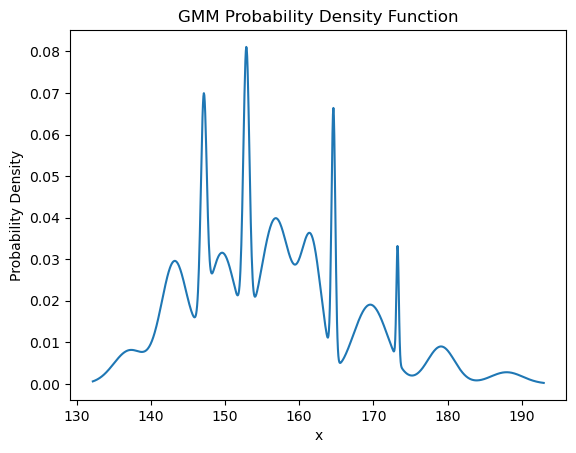

mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


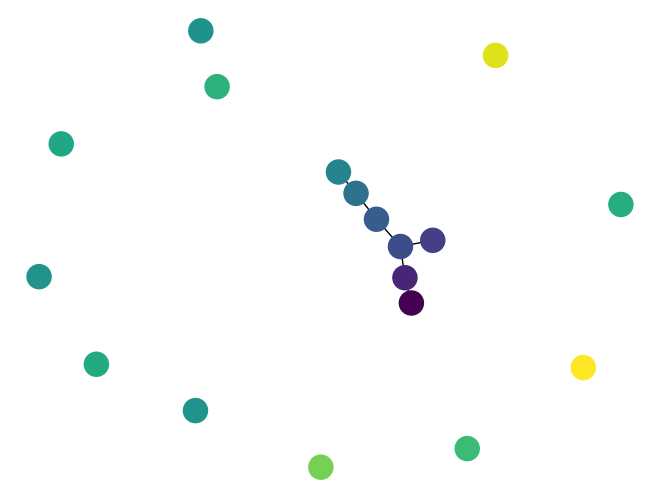

100%|██████████| 400/400 [00:07<00:00, 56.38it/s]


loss: -2.610483905056407
topo_loss: -7.019514703695675
mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


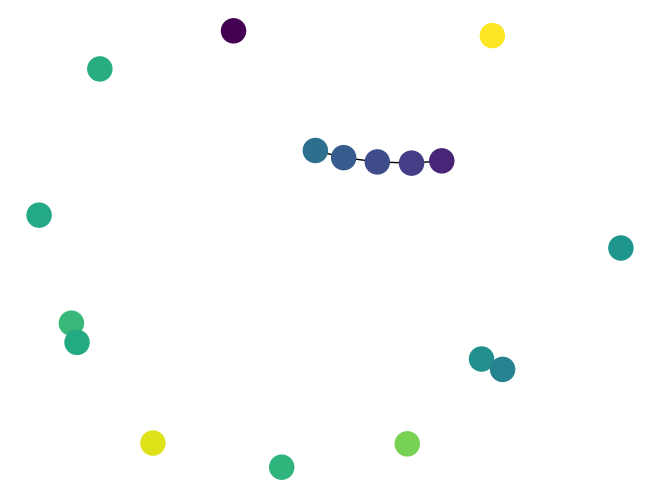

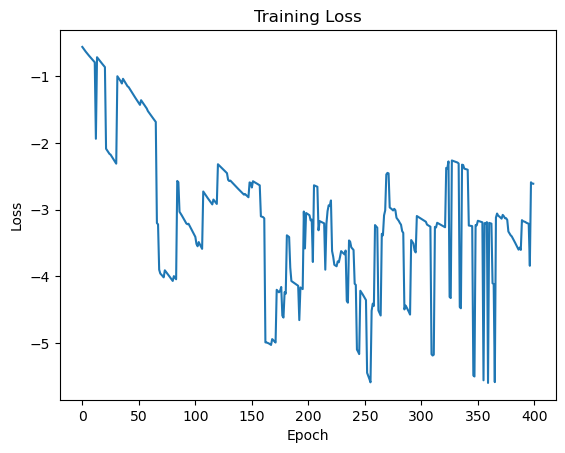

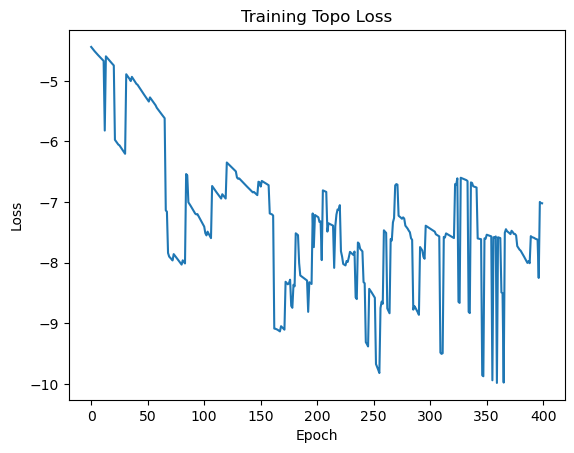

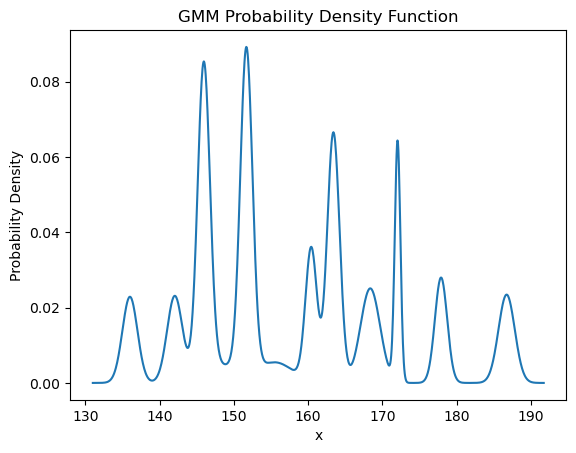

278


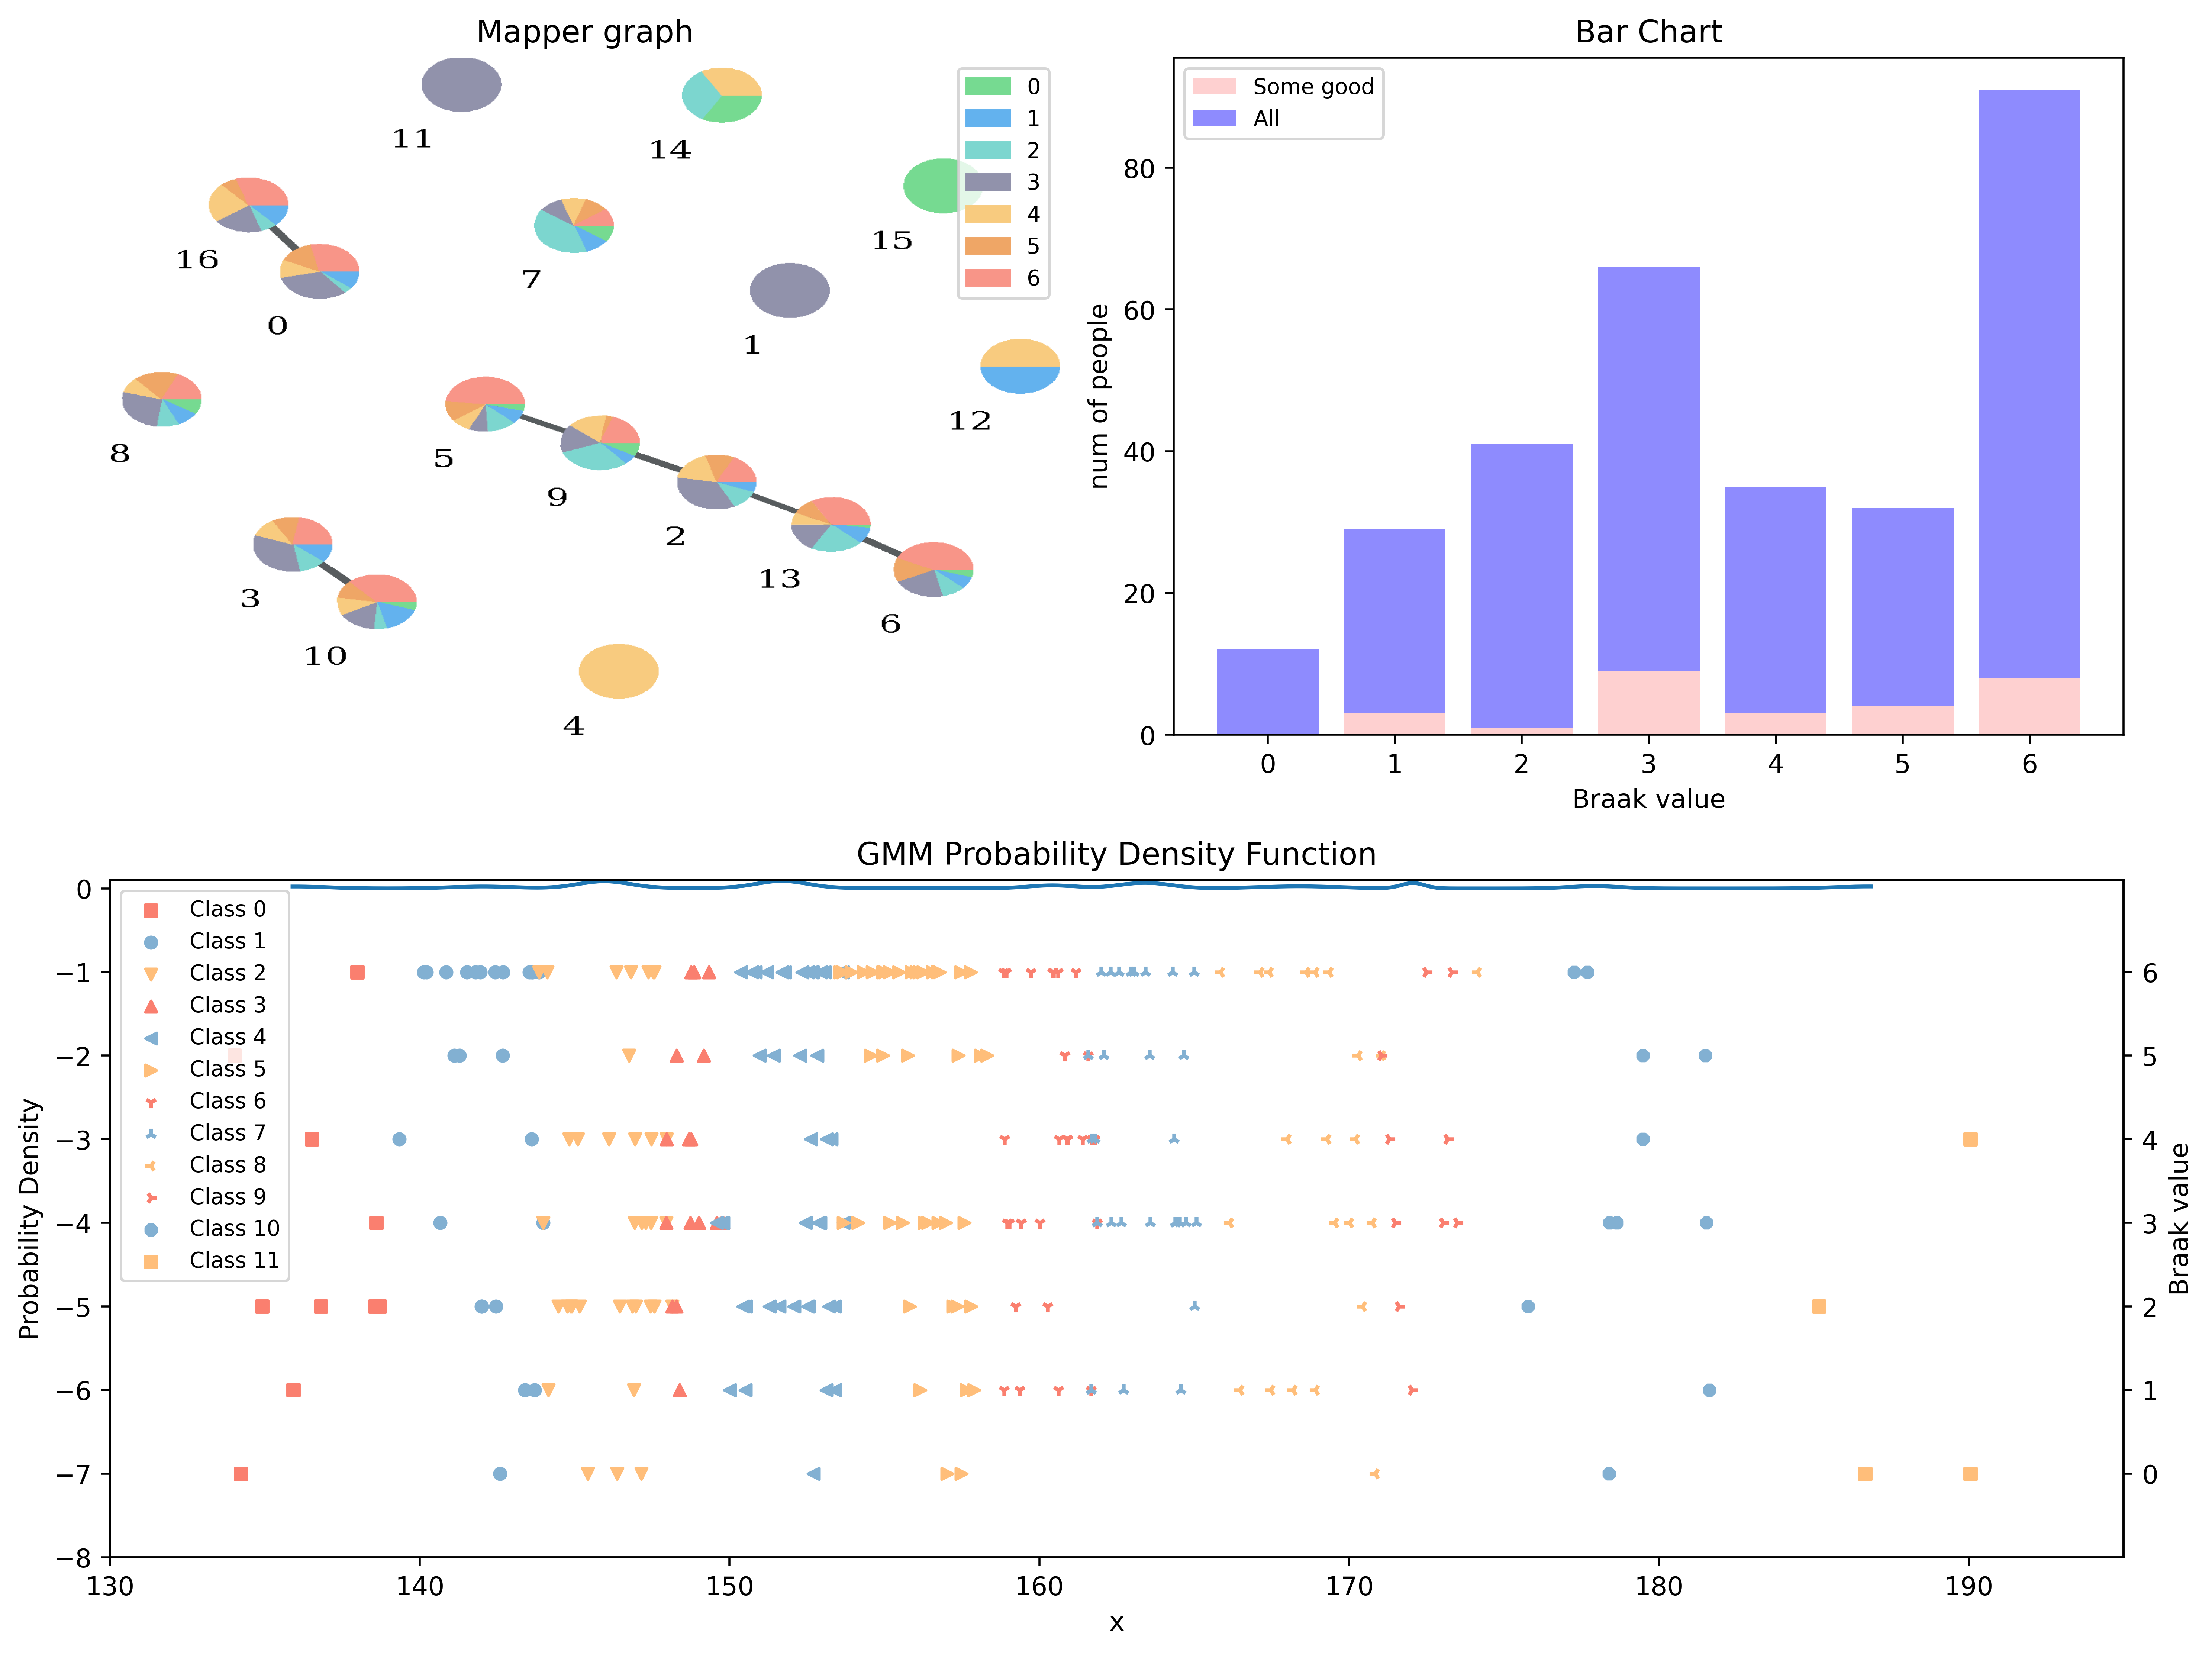

###########
KstestResult(statistic=1.0, pvalue=0.0005827505827505828, statistic_location=9.0, statistic_sign=1)
Have difference!!!


In [10]:
dis_matrix = distance.squareform(distance.pdist(data, metric="euclidean"))
dis_matrix = torch.tensor(dis_matrix)
projected_data = torch.max(dis_matrix,dim = 1)[0]
projected_data = projected_data.view(len(projected_data),1)

n_comp = 12
num_step = 400 
l1 = 1
l2 = 1

mapper = MapperComplex(
input_type="distance matrix",
resolutions=n_comp,
gains=None,
clustering=None,
)
mapper.fit(dis_matrix.numpy(), filters=projected_data.numpy(),colors=projected_data.numpy())

cl = mapper.clustering

# GMM initialization
gmm = GaussianMixture(n_components=n_comp, covariance_type='full', n_init = 10,
                      max_iter= 1000,tol=1e-6,random_state = 0 )
gmm.fit(projected_data)
init_mean = torch.tensor(gmm.means_).view(-1)
init_var = torch.tensor(gmm.covariances_).view(-1)
init_weights = torch.tensor(gmm.weights_).view(-1)

m = Opt_GMM_Mapper(n_comp, means = init_mean, covariances=init_var, weights=init_weights, type = "distance matrix")
m.draw()
init_scheme = m.forward(projected_data, dis_matrix, cl)

# mapper before optimization
mapper = Soft_Mapper.GMM_Soft_Mapper(init_scheme, cl, data = dis_matrix, projected_data =projected_data,path='figures'
                                     ,name = 'MSBB_44',format = 'eps',type="distance matrix")
G_mode = mapper.mode(save_fig= False)

optimizer = optim.Adam(m.parameters(), lr=0.003, betas=(0.9, 0.999), eps=1e-08, weight_decay=1)
scheduler = lr_scheduler.StepLR(optimizer, step_size=400, gamma=0.01)

# train
train = Trainer(m, cl, num_step, optimizer, scheduler)
train.fit(dis_matrix, projected_data, l1, l2)
train.analysis()

# mapper after optimization
G_mode = train.G_mode
clusters = train.mode_clusters
good_nodes = [0] 
analysis_braak(G_mode, train, data_path, projected_data, good_nodes, (130,195),(-8, 0.1))

In [11]:
'''import pandas as pd
data_path = "data/44.tsv"
df = pd.read_csv(data_path, delimiter='\t', index_col=0)
df = df.T
df.to_csv("data/44.csv")

data_path = "data/36.tsv"
df = pd.read_csv(data_path, delimiter='\t', index_col=0)
df = df.T
df.to_csv("data/36.csv")

data_path = "data/22.tsv"
df = pd.read_csv(data_path, delimiter='\t', index_col=0)
df = df.T
df.to_csv("data/22.csv")

data_path = "data/10.tsv"
df = pd.read_csv(data_path, delimiter='\t', index_col=0)
df = df.T
df.to_csv("data/10.csv")'''

'import pandas as pd\ndata_path = "data/44.tsv"\ndf = pd.read_csv(data_path, delimiter=\'\t\', index_col=0)\ndf = df.T\ndf.to_csv("data/44.csv")\n\ndata_path = "data/36.tsv"\ndf = pd.read_csv(data_path, delimiter=\'\t\', index_col=0)\ndf = df.T\ndf.to_csv("data/36.csv")\n\ndata_path = "data/22.tsv"\ndf = pd.read_csv(data_path, delimiter=\'\t\', index_col=0)\ndf = df.T\ndf.to_csv("data/22.csv")\n\ndata_path = "data/10.tsv"\ndf = pd.read_csv(data_path, delimiter=\'\t\', index_col=0)\ndf = df.T\ndf.to_csv("data/10.csv")'